<a href="https://colab.research.google.com/github/Sandracp27/Sandra_Cardona_Proyecto_03_ST/blob/main/Sandra_Cardona_proyecto_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.

#¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



In [389]:
import numpy as np
import pandas as pd
import pylab as plt
from google.colab import drive
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Preprocesado y modelado
# ==============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Metricas
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error

In [2]:
#cargamos los datos

drive.mount('/content/gdrive', force_remount=True)

# Aca deben apuntar a la carpeta de su drive donde guardaron los datos
root_dir = "/content/gdrive/My Drive/Data_Science_Acamica/Proyectos"


Mounted at /content/gdrive


In [3]:
datos=pd.read_csv('/content/gdrive/My Drive/Data_Science_Acamica/Proyectos/owid-covid-data.csv')
datos

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159548,ZWE,Africa,Zimbabwe,2022-01-31,229666.0,206.0,160.714,5338.0,1.0,4.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
159549,ZWE,Africa,Zimbabwe,2022-02-01,229851.0,185.0,153.571,5350.0,12.0,4.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
159550,ZWE,Africa,Zimbabwe,2022-02-02,230012.0,161.0,152.714,5352.0,2.0,4.429,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
159551,ZWE,Africa,Zimbabwe,2022-02-03,230170.0,158.0,153.429,5357.0,5.0,4.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159553 entries, 0 to 159552
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    159553 non-null  object 
 1   continent                                   149974 non-null  object 
 2   location                                    159553 non-null  object 
 3   date                                        159553 non-null  object 
 4   total_cases                                 156678 non-null  float64
 5   new_cases                                   156613 non-null  float64
 6   new_cases_smoothed                          155462 non-null  float64
 7   total_deaths                                139109 non-null  float64
 8   new_deaths                                  139265 non-null  float64
 9   new_deaths_smoothed                         139135 non-null  float64
 

Con el método **.info()**  podemos encontrar  el resumen  de todas las columnas con sus tipos de datos y el número de valores no nulos en cada columna. Se tiene 159553 instancias y 67 Columnas, adicionalmente vemos que date tiene caracteres (string) por lo que mas adelante los vamos a tener que pasar a variables númericas.
Adicionalmente vamos a corroborar que variables son categorica y cuales  numerica, los cuales pudimos ver con el metodo info().

In [5]:
var_num = []
var_cat = []

for i in datos.columns:
  if datos.dtypes[i] != "object":
    var_num.append(i)
  else :
    var_cat.append(i)

print(f"Variables de tipo categoricas: {var_cat}")
print(f"Variables de tipo numericas: {var_num}")

Variables de tipo categoricas: ['iso_code', 'continent', 'location', 'date', 'tests_units']
Variables de tipo numericas: ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated

In [6]:
# Para convertir la fecha a númerica se va utilizar el método to_datetime de pandas.
datos.date = pd.to_datetime(datos.date, format="%Y-%m-%d")

In [7]:
datos.sort_values('date', inplace = True)
datos.reset_index(drop=True, inplace = True)

Primero se va a identificar si existe alguna columna con un solo valor y si es el caso se debe eliminar

In [8]:
for i in range(datos.shape[1]):
    print(datos.columns.values[i],len(pd.unique(datos.iloc[:,i])))

iso_code 238
continent 7
location 238
date 766
total_cases 85712
new_cases 20655
new_cases_smoothed 37987
total_deaths 33841
new_deaths 4416
new_deaths_smoothed 10260
total_cases_per_million 116796
new_cases_per_million 64051
new_cases_smoothed_per_million 73474
total_deaths_per_million 74866
new_deaths_per_million 9337
new_deaths_smoothed_per_million 10862
reproduction_rate 387
icu_patients 3691
icu_patients_per_million 10545
hosp_patients 7221
hosp_patients_per_million 16399
weekly_icu_admissions 1499
weekly_icu_admissions_per_million 3011
weekly_hosp_admissions 5339
weekly_hosp_admissions_per_million 8614
new_tests 35346
total_tests 65987
total_tests_per_thousand 60426
new_tests_per_thousand 11266
new_tests_smoothed 40007
new_tests_smoothed_per_thousand 11501
positive_rate 4768
tests_per_case 6930
tests_units 5
total_vaccinations 41777
people_vaccinated 39439
people_fully_vaccinated 36253
total_boosters 11001
new_vaccinations 29347
new_vaccinations_smoothed 40679
total_vaccinations_

Para mayor facilidad de interpretar las variables se van a renombrar.

In [9]:
datos.rename(columns={'date':'fecha', 'location':'pais',},inplace=True)

Vamos a ver cómo es la distribución de la variables realizando boxplots para cada una de ellas.

In [10]:
datos.columns

Index(['iso_code', 'continent', 'pais', 'fecha', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'tota

Se va hacer una exploración de que contiene cada columna para esto se va a realizar mediante un ciclo for donde se pretende determinar la cantidad de variables que hay en cada columna.

In [11]:
for column in datos:
  print('\nNombre de la columna: ', column)
  print('Contenido de la columna: ', datos[column].value_counts().sort_values(ascending=False))


Nombre de la columna:  iso_code
Contenido de la columna:  ARG    766
MEX    766
PER    766
THA    763
TWN    751
      ... 
TUV    179
PLW    167
TKL    114
PCN     85
NIU     43
Name: iso_code, Length: 238, dtype: int64

Nombre de la columna:  continent
Contenido de la columna:  Africa           37822
Europe           35613
Asia             34781
North America    23914
South America     9205
Oceania           8639
Name: continent, dtype: int64

Nombre de la columna:  pais
Contenido de la columna:  Argentina    766
Mexico       766
Peru         766
Thailand     763
Taiwan       751
            ... 
Tuvalu       179
Palau        167
Tokelau      114
Pitcairn      85
Niue          43
Name: pais, Length: 238, dtype: int64

Nombre de la columna:  fecha
Contenido de la columna:  2021-07-29    237
2021-07-28    237
2021-07-02    237
2021-06-28    237
2021-06-27    237
             ... 
2020-01-08      4
2020-01-07      4
2020-01-03      3
2020-01-02      3
2020-01-01      3
Name: fecha, Len

In [12]:
include_world = datos[datos['pais'].values == "World"]
exclude_world= datos[datos['pais'].values != "World"]
world_cov19 = include_world
world_cov19.head()

,iso_code,continent,pais,fecha,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
102,OWID_WRL,NaN,World,2020-01-22,557.0,0.0,NaN,17.0,0.0,NaN,...,6.434,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN
109,OWID_WRL,NaN,World,2020-01-23,655.0,98.0,NaN,18.0,1.0,NaN,...,6.434,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN
143,OWID_WRL,NaN,World,2020-01-24,941.0,286.0,NaN,26.0,8.0,NaN,...,6.434,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN
165,OWID_WRL,NaN,World,2020-01-25,1434.0,493.0,NaN,42.0,16.0,NaN,...,6.434,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN
185,OWID_WRL,NaN,World,2020-01-26,2118.0,684.0,NaN,56.0,14.0,NaN,...,6.434,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN


In [13]:
world_cov19.reset_index(inplace=True)

In [14]:
mensual= world_cov19.resample('W', on='fecha').sum()

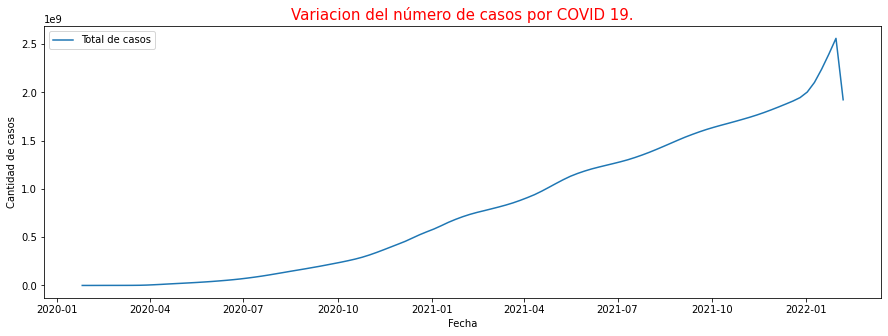

In [15]:
plt.figure(figsize = (15,5))
plt.plot(mensual.index, mensual.total_cases, label = 'Total de casos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de casos')
plt.legend()
plt.title("Variacion del número de casos por COVID 19.", fontsize= 15 , color='red')
plt.show()

En la grafica se puede observar la cantidad total de casos como va incrementando con el paso del tiempo, donde en enero de 2021 los casos a nivel mundial eran cero, hasta que llego a su nivel maximo en enero de 2022 y despues empieza a disminuir.

Ahora se va a realizar una grafica donde se pueda ver la incidencia de nuevos casos según el continente

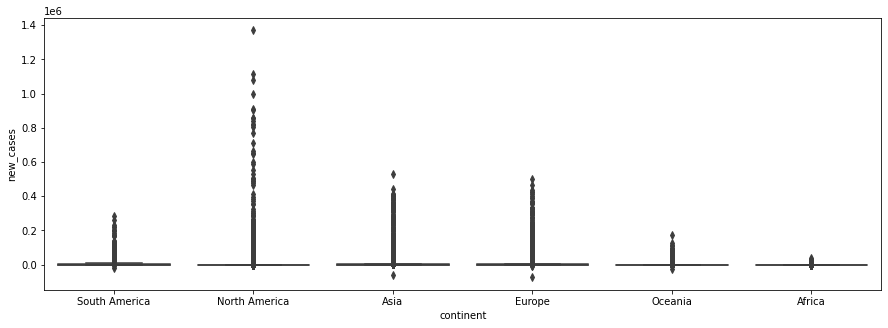

In [16]:
plt.rcParams["figure.figsize"] = (15, 5)
var = 'continent'
fig = sns.boxplot(x=var, y ="new_cases", data=datos)

Como se puede observar Norte America es el continente que presenta mayor número de casos por covid y el pais que presenta menos casos por covid es Africa

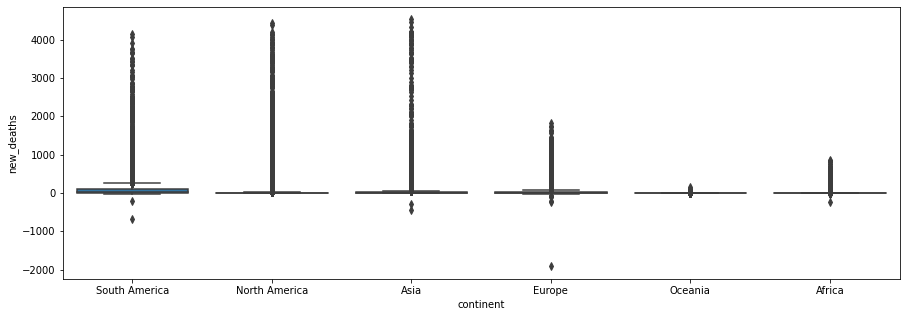

In [17]:
plt.rcParams["figure.figsize"] = (15, 5)
var = 'continent'
fig = sns.boxplot(x=var, y ="new_deaths", data=datos)

Ahora vamos a mirar cuantos paises hay para saber cuales vamos analizar.

In [18]:
datos.pais.nunique()

238

In [19]:
regions = datos["pais"].unique()
for x in regions:
    print(x)

Argentina
Mexico
Peru
Thailand
Greece
Estonia
Latvia
Taiwan
High income
North America
China
Macao
Upper middle income
Asia
Japan
World
United States
Lower middle income
South Korea
Hong Kong
Singapore
European Union
Vietnam
Europe
France
Malaysia
Nepal
Oceania
Australia
Canada
Sri Lanka
Germany
Cambodia
Finland
United Arab Emirates
Philippines
India
Fiji
Italy
United Kingdom
Russia
Sweden
Spain
Denmark
Slovenia
Belgium
International
South Africa
Morocco
Norway
Africa
Egypt
Guatemala
Iran
Israel
Lebanon
South America
Chile
Low income
Oman
Bahrain
Afghanistan
Iraq
Luxembourg
Kuwait
Pakistan
Algeria
Croatia
Albania
Switzerland
Austria
Georgia
Serbia
Brazil
Romania
North Macedonia
Netherlands
Nigeria
Senegal
Iceland
Belarus
New Zealand
Ireland
Lithuania
San Marino
Qatar
Monaco
Portugal
Armenia
Czechia
Dominican Republic
Azerbaijan
Ecuador
Saudi Arabia
Andorra
Indonesia
Hungary
Bangladesh
Jordan
Ukraine
Liechtenstein
Tunisia
Libya
Faeroe Islands
Togo
Poland
Gibraltar
Malta
Palestine
Bosnia 

## **¿Cómo empezó la pandemia?**

1. **Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de k inicial de la pandemia, analizando datos del primer tramo.**

In [20]:
datos_paises = datos[datos.pais.isin(["China", "India", "Indonesia", "Iran", "Israel", "Japan", "Russia", "Thailand", "Taiwan", "Vietnam"])]

In [21]:
datos_paises = datos_paises[['pais', 'total_cases', 'population']].groupby('pais', as_index=False).sum().sort_values('total_cases', ascending=False).head(10)
datos_paises

,pais,total_cases,population
1,India,1.163488e+10,1.026942e+12
6,Russia,2.894992e+09,1.073912e+11
3,Iran,1.676145e+09,6.096562e+10
2,Indonesia,1.198560e+09,1.948351e+11
4,Israel,4.675888e+08,6.652356e+09
5,Japan,4.594657e+08,9.390784e+10
8,Thailand,3.624206e+08,5.337249e+10
9,Vietnam,2.074938e+08,7.303761e+10
0,China,6.511748e+07,1.075941e+12
7,Taiwan,4.343685e+06,1.791511e+10


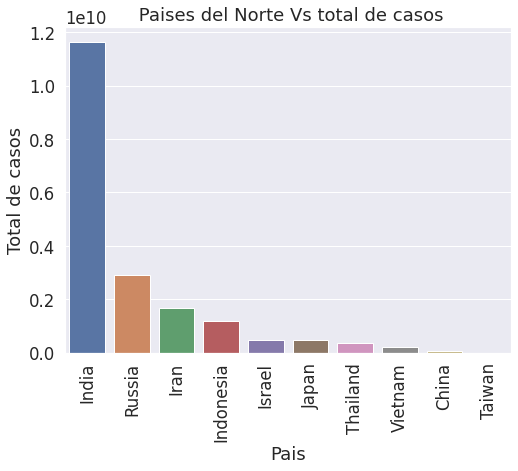

In [22]:
sns.set(font_scale=1.5)
plt.figure(figsize=(8, 6))
plt.xticks(rotation=90)
sns.barplot(data= datos_paises, x='pais', y='total_cases')
plt.xlabel('Pais')
plt.ylabel('Total de casos')
plt.title(' Paises del Norte Vs total de casos')
plt.show()

In [23]:
datos.reset_index(inplace=True) 

In [24]:
paises=datos['pais'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

El crecimiento exponencial es una función matemática que se puede utilizar en varias situaciones. La fórmula nos dice el número de casos en un momento determinado, en el caso del Coronavirus, este es el número de personas infectadas.
La razón para usar el Crecimiento Exponencial para modelar el brote de Coronavirus es que los epidemiólogos han estudiado esos tipos de brotes y es bien sabido que el primer período de una epidemia sigue al Crecimiento Exponencial. 
Se tomaron 10 paises del norte donde comenzo la pandemia y se le realizo una función exponencial 
$C(t)=e^{k(t-t_0)}$, los datos de casos confirmados en función del tiempo $C(t)$. Donde se tomaron los días donde el comportamiento fue mas sostenido y se calculo el número de personas infectadas,  pero se necesito hacer un paso adicional para que nuestro análisis sea útil que fue el de encontrar el factor de crecimiento real de la epidemia de Coronavirus , observando los datos de la propagación de la epidemia.
Al mirar los datos, solo se tiene la cantidad de casos por día y no el factor de crecimiento. La mejor forma para encontrar el factor de crecimiento a partir de observaciones diarias empíricas es usar una Regresión lineal. Para esto se necesita reescribir la fórmula en una forma que tenga la forma de la regresión lineal mediante logaritmos, esto se hizo con cada uno de los 10 paises anteriormente indicados

In [25]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

 Luego se va a determinar una función que determine los casos nuevos por día a partir de estas curvas

In [26]:
def casos_nuevos(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos  

Una vez que se ha encontrado el mejor modelo, se puede utilizar para la predicción. Usando la función que hemos estimado usando la curva de Crecimiento Exponencial, si queremos predecir un tiempo determinado, después del último día del conjunto de datos, simplemente ponemos t igual  a la fecha correspondiente en la fórmula y el modelo predice cuantas infecciones se obtuvo en ese día .

* **Pais 1:** **China** 

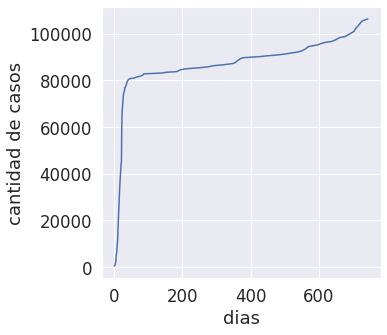

In [27]:
#seleccionamos China
plt.figure(figsize = (5,5))
ind_china=np.where(paises=='China')
ind_china=ind_china[0]
casos_china=confirmados[ind_china]
dias=np.arange(0,len(casos_china))
plt.plot(dias,casos_china)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de China. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


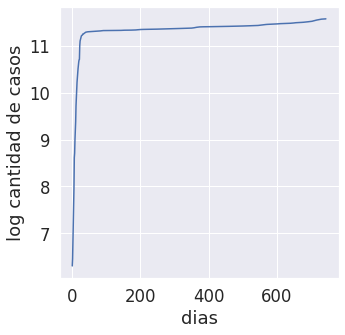

In [28]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_china))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en China, para ver cómo fue el $k$ inicial

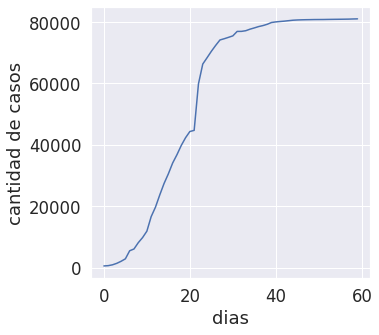

In [29]:
plt.figure(figsize = (5,5))
casos_principio=casos_china[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

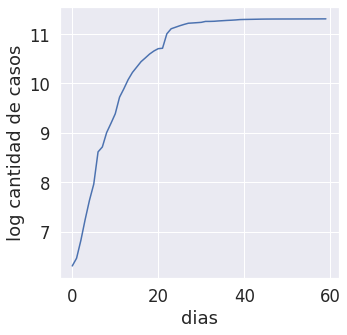

In [30]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 0 y 35, ya que ese fue el comportamiento más sostenido de crecimiento.

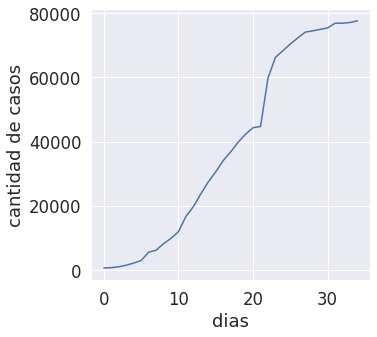

In [31]:
plt.figure(figsize = (5,5))
casos_principio=casos_china[0:35]
dias_principio=dias[0:35]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

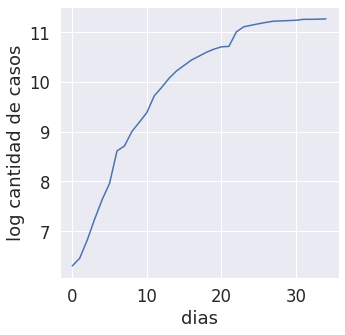

In [32]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [33]:
dias_principio

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [34]:
casos_principio

95        547.0
115       639.0
145       916.0
170      1399.0
179      2062.0
217      2863.0
235      5494.0
267      6070.0
315      8124.0
352      9783.0
406     11871.0
441     16607.0
460     19693.0
526     23680.0
557     27409.0
594     30553.0
666     34075.0
675     36778.0
760     39790.0
795     42306.0
816     44327.0
890     44699.0
952     59832.0
980     66292.0
1055    68347.0
1071    70446.0
1145    72364.0
1160    74139.0
1215    74546.0
1300    74999.0
1358    75472.0
1388    76922.0
1466    76938.0
1486    77152.0
1568    77660.0
Name: total_cases, dtype: float64

Luego, podemos usar esta función para calcular el valor de C para cada valor de t de 0 a 34. Cuando hacemos esto, obtenemos los siguientes números de personas infectadas en cada paso de tiempo, como se ve en la lista de casos_principio. Esto demuestra que partiendo de 95 personas y con un factor de crecimiento  obtenemos más de 77660 casos a los 34 días.

In [35]:
exponencial

<function __main__.exponencial>

In [36]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([ 6.38634508e-02, -1.45890471e+02])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

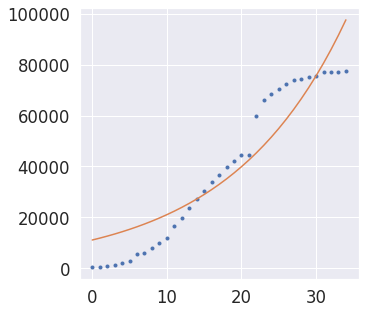

In [37]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

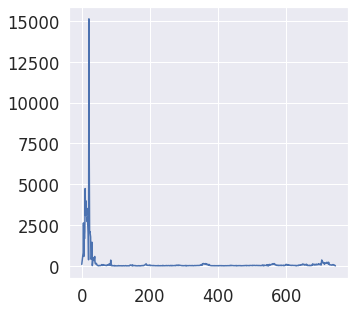

In [38]:
plt.figure(figsize = (5,5))
casos_china=np.array(casos_china)
nuevos_china=casos_nuevos(casos_china)
plt.plot(nuevos_china)

In [39]:
rmse_china = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_china))

1.0519853561265159e+08


In [40]:
t0_china = dias_principio[0]
t_china = dias_principio[-1]
k_china = k
rmse_china = rmse_china

dic_china = {"Pais": "China", "t0":[t0_china], "t":[t_china], "k": [k_china], "rmse_china":[rmse_china]}
datos_china = pd.DataFrame(data=dic_china)
datos_china

,Pais,t0,t,k,rmse_china
0,China,0,34,0.063863,1.051985e+08


* **Pais 2:** **India**

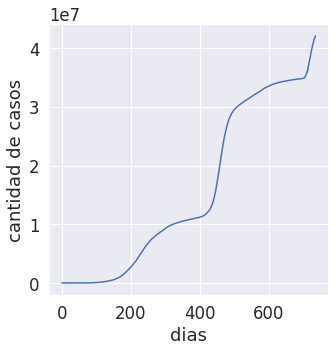

In [41]:
plt.figure(figsize = (5,5))
ind_india=np.where(paises=='India')
ind_india=ind_india[0]
casos_india=confirmados[ind_india]
dias=np.arange(0,len(casos_india))
plt.plot(dias,casos_india)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de India. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

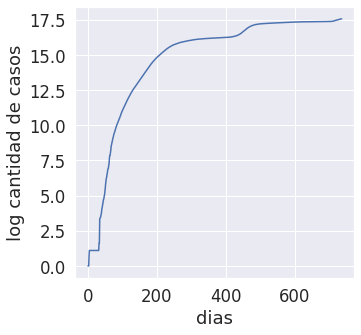

In [42]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_india))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en India, para ver cómo fue el $k$ inicial

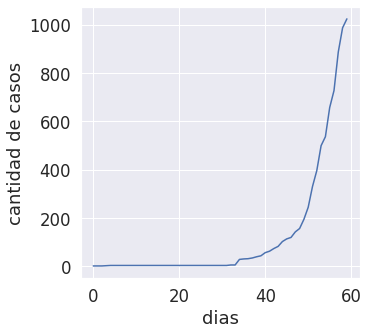

In [43]:
plt.figure(figsize = (5,5))
casos_principio=casos_india[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

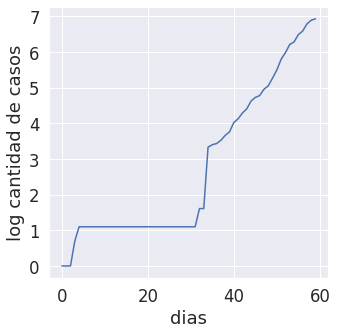

In [44]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 31 y 55, ya que ese fue el comportamiento más sostenido.

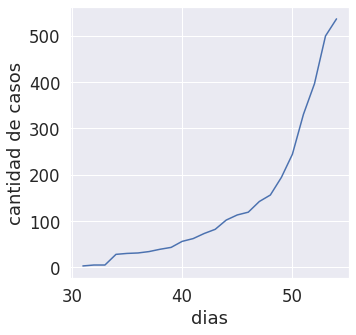

In [45]:
plt.figure(figsize = (5,5))
casos_principio=casos_india[31:55]
dias_principio=dias[31:55]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

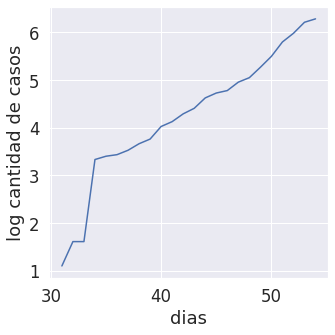

In [46]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [47]:
dias_principio

array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54])

In [48]:
casos_principio

1995      3.0
2096      5.0
2179      5.0
2273     28.0
2317     30.0
2454     31.0
2602     34.0
2674     39.0
2868     43.0
2964     56.0
3155     62.0
3210     73.0
3347     82.0
3465    102.0
3745    113.0
3833    119.0
4019    142.0
4215    156.0
4291    194.0
4485    244.0
4766    330.0
4887    396.0
5081    499.0
5375    536.0
Name: total_cases, dtype: float64

In [49]:
exponencial

<function __main__.exponencial>

In [50]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([ 0.18372089, 19.60584759])

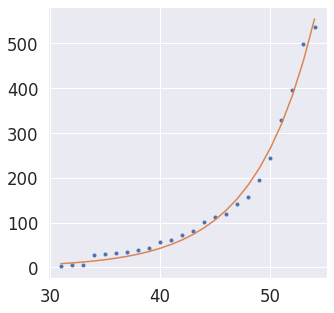

In [51]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

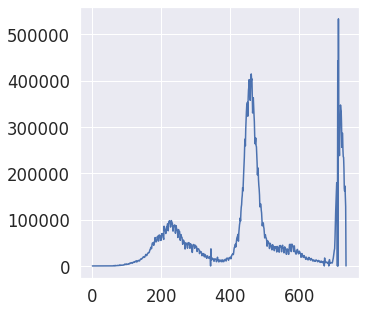

In [52]:
plt.figure(figsize = (5,5))
casos_india=np.array(casos_india)
nuevos_india=casos_nuevos(casos_india)
plt.plot(nuevos_india)

In [53]:
rmse_india = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_india))

2.4161334876002556e+02


In [54]:
t0_india = dias_principio[0]
t_india = dias_principio[-1]
k_india = k
rmse_india = rmse_india

dic_india = {"Pais": "India", "t0":[t0_india], "t":[t_india], "k": [k_india], "rmse":[rmse_india]}
datos_india = pd.DataFrame(data=dic_india)
datos_india

,Pais,t0,t,k,rmse
0,India,31,54,0.183721,241.613349


* **Pais 3: Rusia**

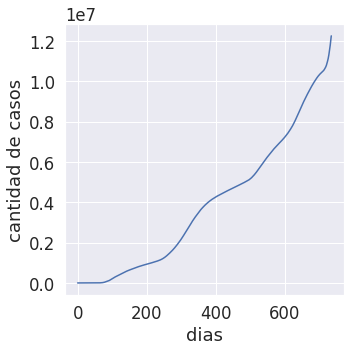

In [55]:
plt.figure(figsize = (5,5))
ind_rusia=np.where(paises=='Russia')
ind_rusia=ind_rusia[0]
casos_rusia=confirmados[ind_rusia]
dias=np.arange(0,len(casos_rusia))
plt.plot(dias,casos_rusia)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de Rusia. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

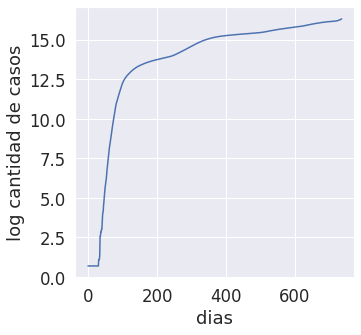

In [56]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_rusia))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Rusia, para ver cómo fue el $k$ inicial

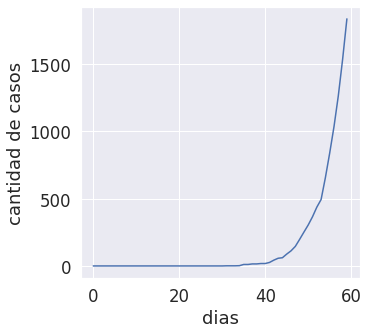

In [57]:
plt.figure(figsize = (5,5))
casos_principio=casos_rusia[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

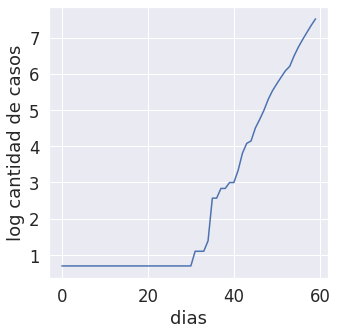

In [58]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 25 y 60, ya que ese fue el comportamiento más sostenido.

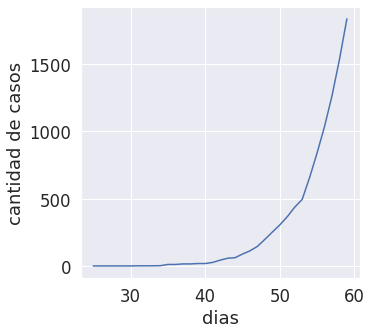

In [59]:
plt.figure(figsize = (5,5))
casos_principio=casos_rusia[25:60]
dias_principio=dias[25:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

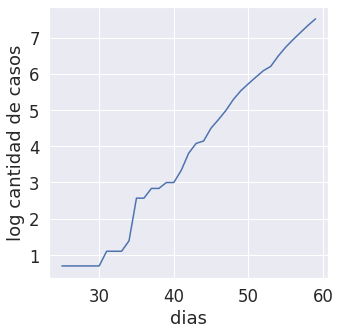

In [60]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [61]:
dias_principio

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59])

In [62]:
casos_principio

1541       2.0
1668       2.0
1722       2.0
1815       2.0
1901       2.0
1947       2.0
2046       3.0
2125       3.0
2219       3.0
2418       4.0
2445      13.0
2549      13.0
2721      17.0
2864      17.0
3025      20.0
3034      20.0
3178      28.0
3431      45.0
3503      59.0
3736      63.0
3895      90.0
4023     114.0
4125     147.0
4409     199.0
4585     253.0
4671     306.0
4966     367.0
5207     438.0
5378     495.0
5607     658.0
5658     840.0
5892    1036.0
6205    1264.0
6242    1534.0
6486    1836.0
Name: total_cases, dtype: float64

In [63]:
exponencial

<function __main__.exponencial>

In [64]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([ 0.20641631, 22.50007882])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

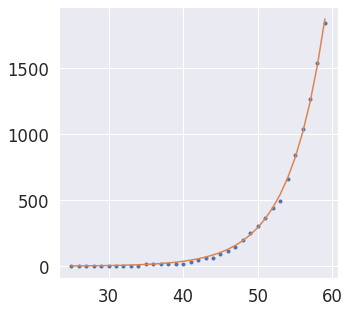

In [65]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

En la grafica se puede observar que los datos se ajustan a los reales.

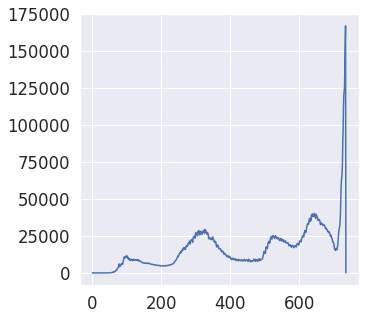

In [66]:
plt.figure(figsize = (5,5))
casos_rusia=np.array(casos_rusia)
nuevos_rusia=casos_nuevos(casos_rusia)
plt.plot(nuevos_rusia)

In [67]:
rmse_rusia = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_rusia))

2.3452816102799122e+02


In [68]:
t0_rusia = dias_principio[0]
t_rusia = dias_principio[-1]
k_rusia = k
rmse_rusia = rmse_rusia

dic_rusia = {"Pais": "Russia", "t0":[t0_rusia], "t":[t_rusia], "k": [k_rusia], "rmse_rusia":[rmse_rusia]}
datos_rusia = pd.DataFrame(data=dic_rusia)
datos_rusia

,Pais,t0,t,k,rmse_rusia
0,Russia,25,59,0.206416,234.528161


* **Pais 4 : Iran**

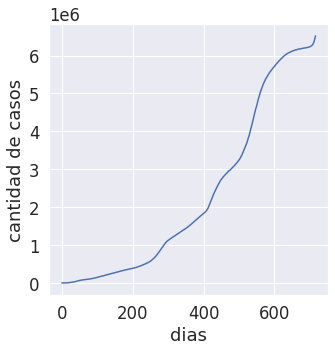

In [69]:
plt.figure(figsize = (5,5))
ind_iran=np.where(paises=='Iran')
ind_iran =ind_iran[0]
casos_iran=confirmados[ind_iran]
dias=np.arange(0,len(casos_iran))
plt.plot(dias,casos_iran)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de Iran. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

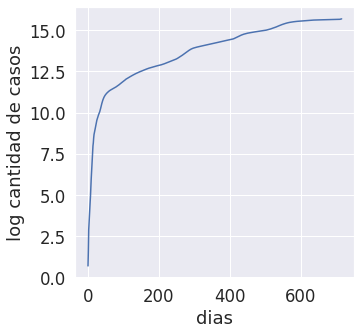

In [70]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_iran))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Iran, para ver cómo fue el $k$ inicial

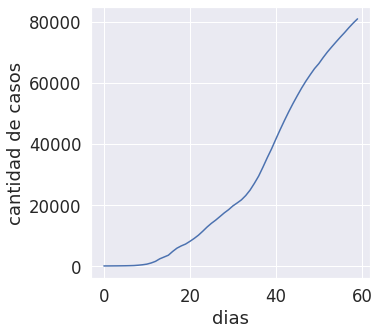

In [71]:
plt.figure(figsize = (5,5))
casos_principio=casos_iran[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

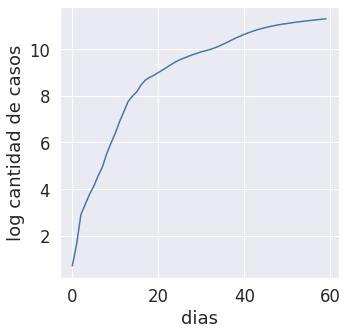

In [72]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 1 y 30, ya que ese fue el comportamiento más sostenido.

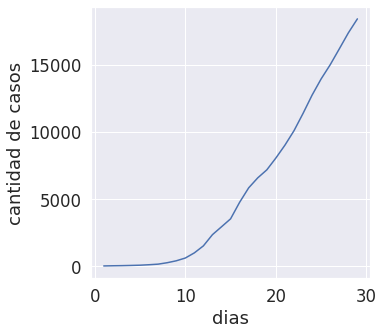

In [73]:
plt.figure(figsize = (5,5))
casos_principio=casos_iran[1:30]
dias_principio=dias[1:30]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

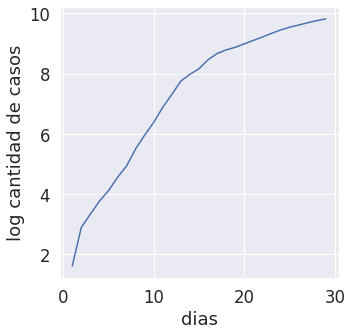

In [74]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [75]:
dias_principio

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [76]:
casos_principio

1268        5.0
1338       18.0
1400       28.0
1465       43.0
1528       61.0
1582       95.0
1608      139.0
1719      245.0
1786      388.0
1877      593.0
1992      978.0
2091     1501.0
2197     2336.0
2251     2922.0
2329     3513.0
2531     4747.0
2592     5823.0
2685     6566.0
2905     7161.0
2942     8042.0
3088     9000.0
3229    10075.0
3377    11364.0
3594    12729.0
3705    13938.0
3841    14991.0
3929    16169.0
4110    17361.0
4423    18407.0
Name: total_cases, dtype: float64

In [77]:
exponencial

<function __main__.exponencial>

In [78]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([  0.11824802, -54.98356674])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

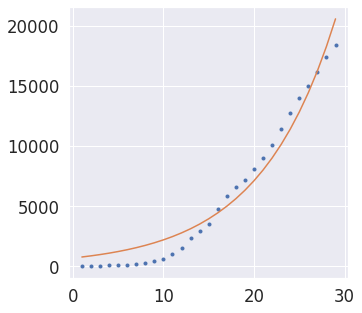

In [79]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

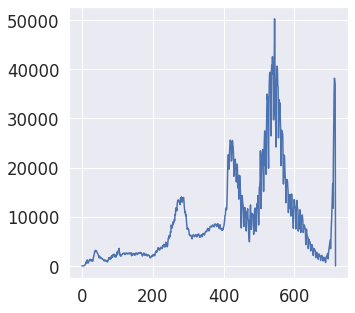

In [80]:
plt.figure(figsize = (5,5))
casos_iran=np.array(casos_iran)
nuevos_iran=casos_nuevos(casos_iran)
plt.plot(nuevos_iran)

In [81]:
rmse_iran = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_iran))

1.236519404602118e+06


In [82]:
t0_iran = dias_principio[0]
t_iran = dias_principio[-1]
k_iran = k
rmse_iran = rmse_iran

dic_iran = {"Pais": "Iran", "t0":[t0_iran], "t":[t_iran], "k": [k_iran], "rmse_iran":[rmse_iran]}
datos_iran = pd.DataFrame(data=dic_iran)
datos_iran

,Pais,t0,t,k,rmse_iran
0,Iran,1,29,0.118248,1.236519e+06


* **Pais 5: Indonesia**

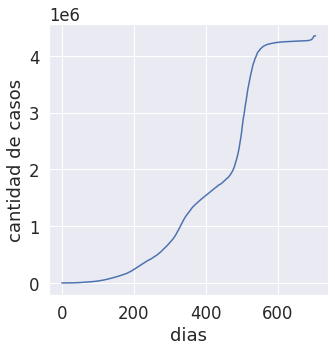

In [83]:
plt.figure(figsize = (5,5))
ind_indonesia=np.where(paises=='Indonesia')
ind_indonesia=ind_indonesia[0]
casos_indonesia=confirmados[ind_indonesia]
dias=np.arange(0,len(casos_indonesia))
plt.plot(dias,casos_indonesia)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de Indonesia. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

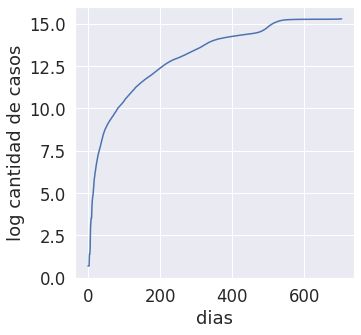

In [84]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_indonesia))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

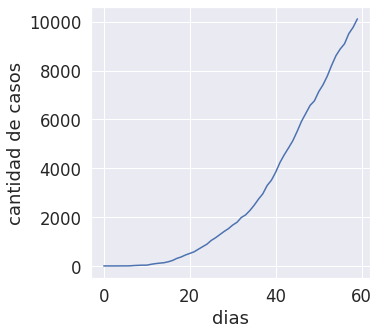

In [85]:
plt.figure(figsize = (5,5))
casos_principio=casos_indonesia[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

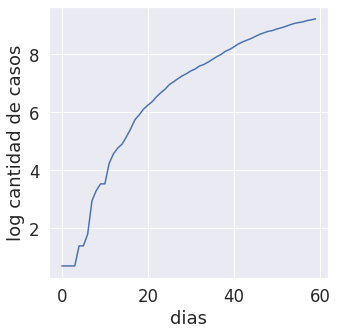

In [86]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 1 y 35, ya que ese fue el comportamiento más sostenido.

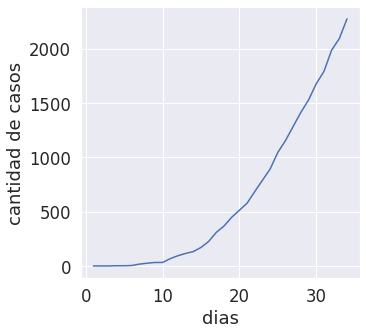

In [87]:
plt.figure(figsize = (5,5))
casos_principio=casos_indonesia[1:35]
dias_principio=dias[1:35]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

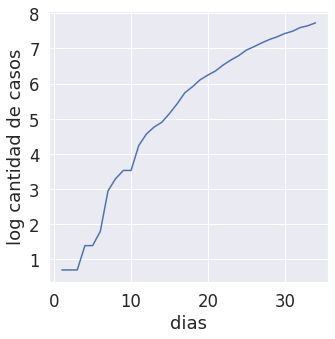

In [88]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [89]:
dias_principio

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [90]:
casos_principio

2144       2.0
2216       2.0
2368       2.0
2449       4.0
2554       4.0
2703       6.0
2877      19.0
2911      27.0
3161      34.0
3200      34.0
3352      69.0
3554      96.0
3718     117.0
3832     134.0
4069     172.0
4178     227.0
4312     311.0
4519     369.0
4773     450.0
4851     514.0
5090     579.0
5315     686.0
5488     790.0
5723     893.0
5847    1046.0
6070    1155.0
6228    1285.0
6574    1414.0
6815    1528.0
6892    1677.0
7131    1790.0
7290    1986.0
7621    2092.0
7727    2273.0
Name: total_cases, dtype: float64

In [91]:
exponencial

<function __main__.exponencial>

In [92]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([  0.11189257, -35.84629246])

Como se ajusta a los datos reales

Ahora necesitamos encontrar el factor de crecimiento real de la epidemia de Corona , observando los datos de la propagación de la epidemia.

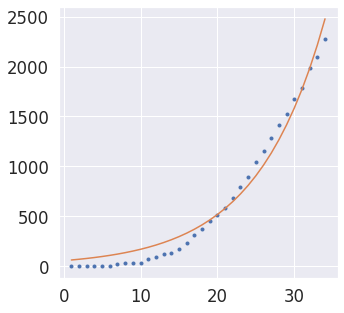

In [93]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

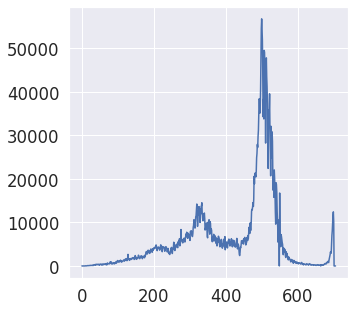

In [94]:
plt.figure(figsize = (5,5))
casos_indonesia=np.array(casos_indonesia)
nuevos_indonesia=casos_nuevos(casos_indonesia)
plt.plot(nuevos_indonesia)

In [95]:
rmse_indonesia = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_indonesia))

1.0621655276295643e+04


In [96]:
t0_indonesia = dias_principio[0]
t_indonesia = dias_principio[-1]
k_indonesia = k
rmse_idonesia = rmse_indonesia

dic_indonesia = {"Pais": "Indonesia", "t0":[t0_indonesia], "t":[t_indonesia], "k": [k_indonesia],"rmse_indonesia":[rmse_indonesia]}
datos_indonesia = pd.DataFrame(data=dic_indonesia)
datos_indonesia

,Pais,t0,t,k,rmse_indonesia
0,Indonesia,1,34,0.111893,10621.655276


* **Pais 6: Israel**

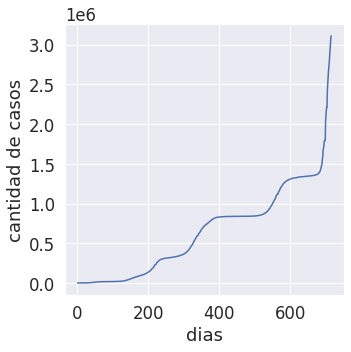

In [97]:
plt.figure(figsize = (5,5))
ind_israel=np.where(paises=='Israel')
ind_israel=ind_israel[0]
casos_israel=confirmados[ind_israel]
dias=np.arange(0,len(casos_israel))
plt.plot(dias,casos_israel)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de Israel. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

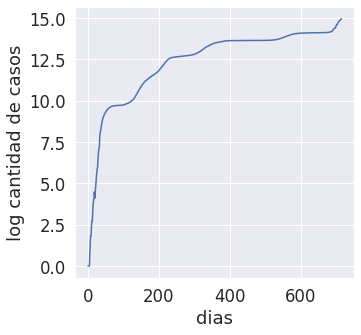

In [98]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_israel))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

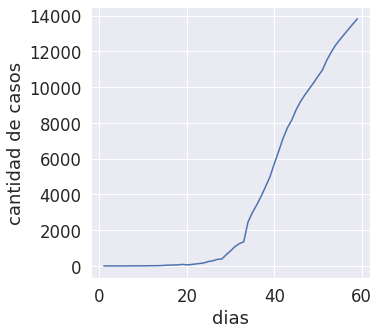

In [99]:
plt.figure(figsize = (5,5))
casos_principio=casos_israel[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

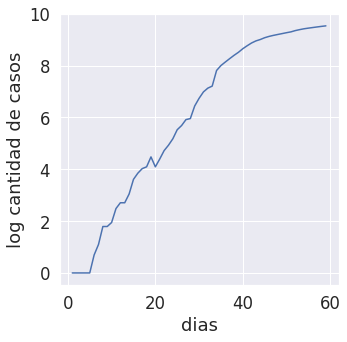

In [100]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 2 y 38, ya que ese fue el comportamiento más sostenido.

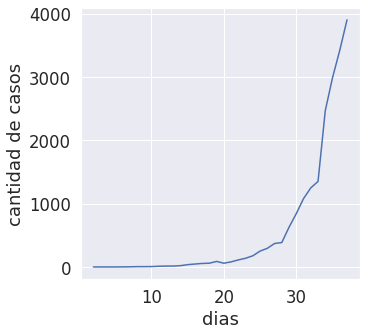

In [101]:
plt.figure(figsize = (5,5))
casos_principio=casos_israel[2:38]
dias_principio=dias[2:38]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

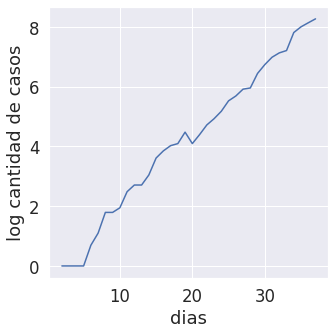

In [102]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [103]:
dias_principio

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37])

In [104]:
casos_principio

1398       1.0
1467       1.0
1519       1.0
1556       1.0
1602       2.0
1696       3.0
1823       6.0
1856       6.0
1976       7.0
2035      12.0
2147      15.0
2308      15.0
2361      21.0
2481      37.0
2569      47.0
2696      56.0
2823      60.0
2920      88.0
3107      60.0
3247      81.0
3337     112.0
3499     138.0
3668     177.0
3802     251.0
4088     295.0
4226     371.0
4404     386.0
4467     628.0
4736     843.0
4865    1080.0
5168    1249.0
5222    1351.0
5555    2468.0
5767    2988.0
5940    3421.0
6052    3901.0
Name: total_cases, dtype: float64

In [105]:
exponencial

<function __main__.exponencial>

In [106]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([0.22806306, 0.44240687])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

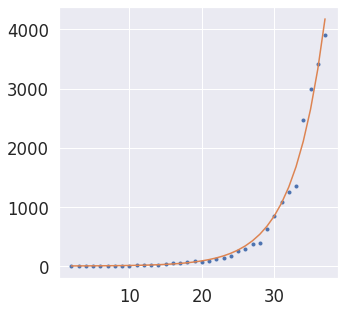

In [107]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

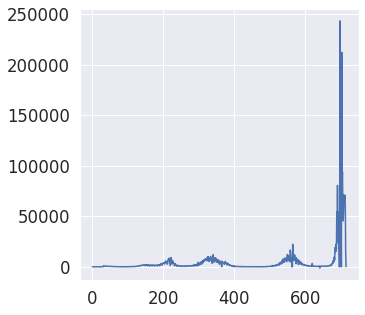

In [108]:
plt.figure(figsize = (5,5))
casos_israel=np.array(casos_israel)
nuevos_israel=casos_nuevos(casos_israel)
plt.plot(nuevos_israel)

In [109]:
rmse_israel = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_israel))

1.3382949042152717e+04


In [110]:
t0_israel = dias_principio[0]
t_israel = dias_principio[-1]
k_israel = k
rmse_israel = rmse_israel

dic_israel = {"Pais": "Israel", "t0":[t0_israel], "t":[t_israel], "k": [k_israel], "rmse_irsrael":[rmse_israel]}
datos_israel = pd.DataFrame(data=dic_israel)
datos_israel

,Pais,t0,t,k,rmse_irsrael
0,Israel,2,37,0.228063,13382.949042


* **Pais 7: Japon**

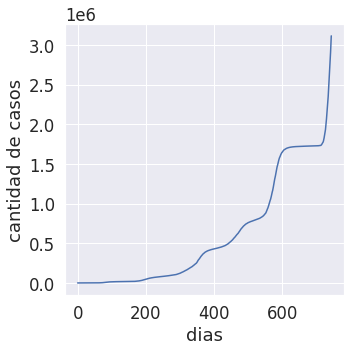

In [111]:
plt.figure(figsize = (5,5))
ind_japan=np.where(paises=='Japan')
ind_japan=ind_japan[0]
casos_japan=confirmados[ind_japan]
dias=np.arange(0,len(casos_japan))
plt.plot(dias,casos_japan)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de Japon. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

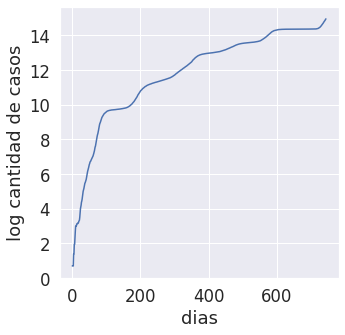

In [112]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_japan))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Japon, para ver cómo fue el $k$ inicial

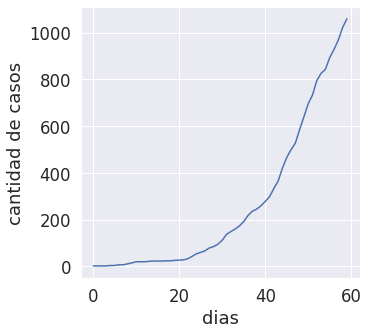

In [113]:
plt.figure(figsize = (5,5))
casos_principio=casos_japan[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

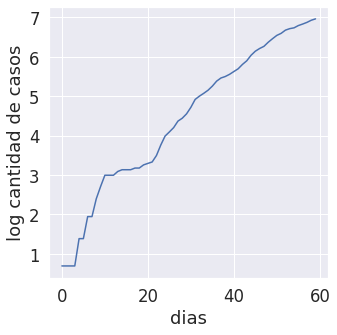

In [114]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 2 y 35, ya que ese fue el comportamiento más sostenido.

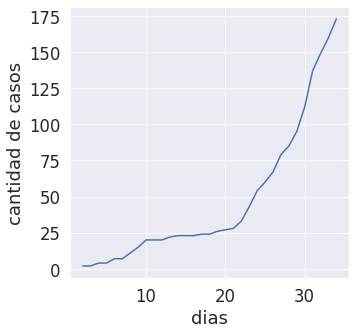

In [115]:
plt.figure(figsize = (5,5))
casos_principio=casos_japan[2:35]
dias_principio=dias[2:35]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

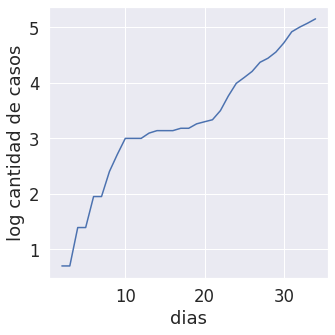

In [116]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [117]:
dias_principio

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [118]:
casos_principio

136       2.0
173       2.0
188       4.0
208       4.0
264       7.0
291       7.0
325      11.0
343      15.0
385      20.0
418      20.0
485      20.0
522      22.0
544      23.0
601      23.0
644      23.0
672      24.0
738      24.0
808      26.0
849      27.0
909      28.0
929      33.0
969      43.0
1030     54.0
1060     60.0
1119     67.0
1189     79.0
1250     85.0
1294     95.0
1332    112.0
1396    137.0
1468    149.0
1516    160.0
1554    173.0
Name: total_cases, dtype: float64

In [119]:
exponencial

<function __main__.exponencial>

In [120]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([ 0.12021023, -9.20074658])

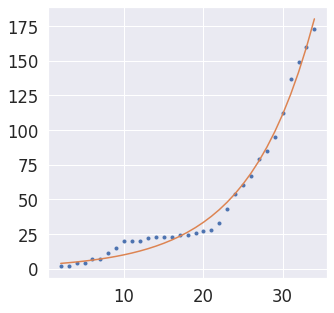

In [121]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

En la grafica anterior se puede ver que los datos se ajustan a los reales.

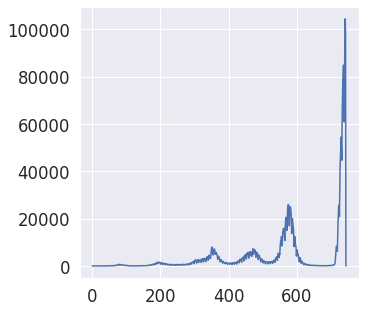

In [122]:
plt.figure(figsize = (5,5))
casos_japan=np.array(casos_japan)
nuevos_japan=casos_nuevos(casos_japan)
plt.plot(nuevos_japan)

In [123]:
rmse_japon = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_japon))

2.8782937311075532e+01


In [124]:
t0_japon = dias_principio[0]
t_japon = dias_principio[-1]
k_japon = k
rmse_japon = rmse_japon

dic_japon = {"Pais": "Japan", "t0":[t0_japon], "t":[t_japon], "k": [k_japon], "rmse_japon":[rmse_japon]}
datos_japon = pd.DataFrame(data=dic_japon)
datos_japon

,Pais,t0,t,k,rmse_japon
0,Japan,2,34,0.12021,28.782937


* **Pais 8: Thailand**

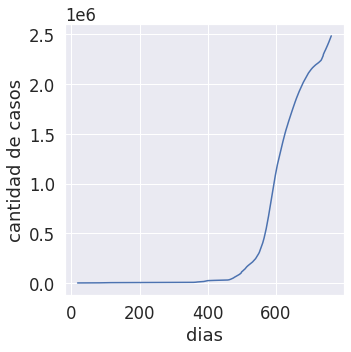

In [125]:
plt.figure(figsize = (5,5))
ind_thailand=np.where(paises=='Thailand')
ind_thailand=ind_thailand[0]
casos_thailand=confirmados[ind_thailand]
dias=np.arange(0,len(casos_thailand))
plt.plot(dias,casos_thailand)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de Thailand. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

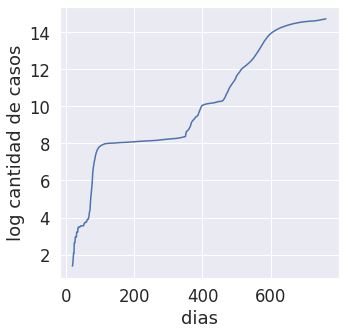

In [126]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_thailand))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Thailand, para ver cómo fue el $k$ inicial

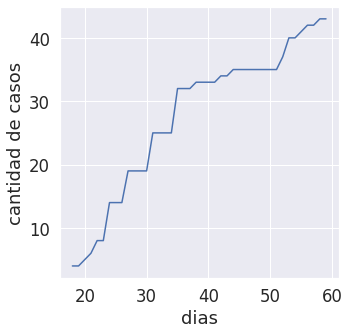

In [127]:
plt.figure(figsize = (5,5))
casos_principio=casos_thailand[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

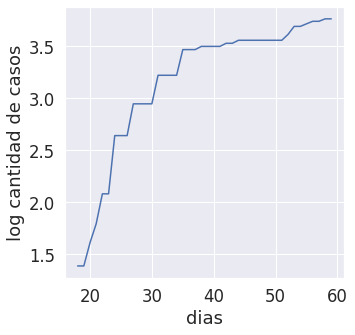

In [128]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 20 y 55, ya que ese fue el comportamiento más sostenido.

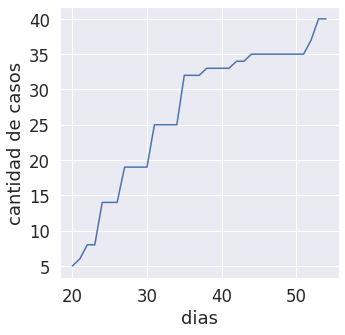

In [129]:
plt.figure(figsize = (5,5))
casos_principio=casos_thailand[20:55]
dias_principio=dias[20:55]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

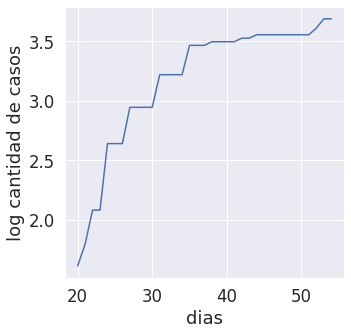

In [130]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [131]:
dias_principio

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54])

In [132]:
casos_principio

149      5.0
167      6.0
203      8.0
214      8.0
245     14.0
282     14.0
299     14.0
338     19.0
373     19.0
437     19.0
472     19.0
512     25.0
575     25.0
586     25.0
667     25.0
692     32.0
751     32.0
810     32.0
853     33.0
902     33.0
942     33.0
988     33.0
1028    34.0
1058    34.0
1107    35.0
1176    35.0
1255    35.0
1305    35.0
1353    35.0
1382    35.0
1427    35.0
1489    35.0
1599    37.0
1666    40.0
1714    40.0
Name: total_cases, dtype: float64

In [133]:
exponencial

<function __main__.exponencial>

In [134]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([ 3.16006908e-02, -6.56884517e+01])

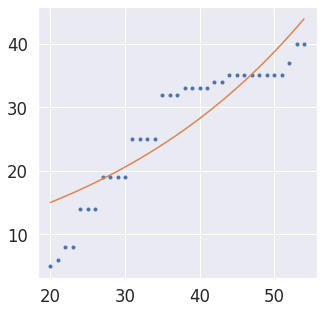

In [135]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

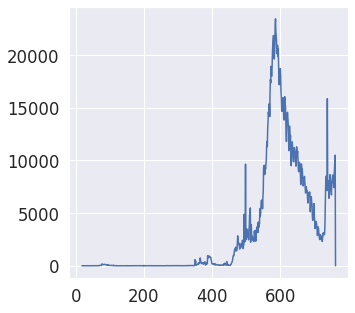

In [136]:
plt.figure(figsize = (5,5))
casos_thailand=np.array(casos_thailand)
nuevos_thailand=casos_nuevos(casos_thailand)
plt.plot(nuevos_thailand)

In [137]:
rmse_thailand = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_thailand))

2.2566500903235543e+01


In [138]:
t0_thailand = dias_principio[0]
t_thailand = dias_principio[-1]
k_thailand = k
rmse_thailand = rmse_thailand

dic_thailand = {"Pais": "Thailand", "t0":[t0_thailand], "t":[t_thailand], "k": [k_thailand], "rmse_thailand":[rmse_thailand]}
datos_thailand = pd.DataFrame(data=dic_thailand)
datos_thailand

,Pais,t0,t,k,rmse_thailand
0,Thailand,20,54,0.031601,22.566501


* **Pais 9: Vietnam**

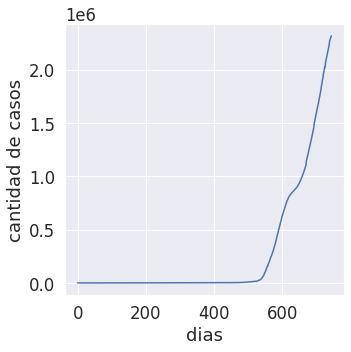

In [139]:
plt.figure(figsize = (5,5))
ind_vietnam=np.where(paises=='Vietnam')
ind_vietnam=ind_vietnam[0]
casos_vietnam=confirmados[ind_vietnam]
dias=np.arange(0,len(casos_vietnam))
plt.plot(dias,casos_vietnam)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de Vietnam. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

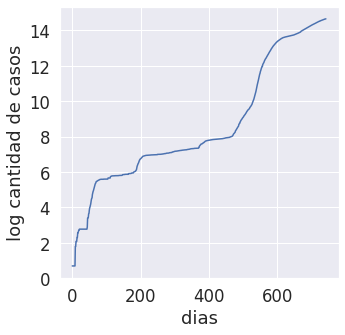

In [140]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_vietnam))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Vietnam, para ver cómo fue el $k$ inicial

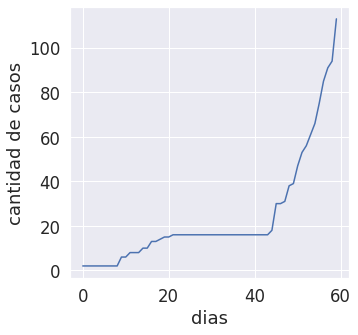

In [141]:
plt.figure(figsize = (5,5))
casos_principio=casos_vietnam[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

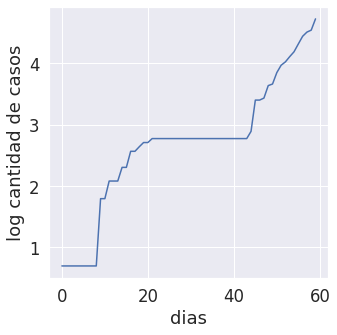

In [142]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 8 y 20, ya que ese fue el comportamiento más sostenido.

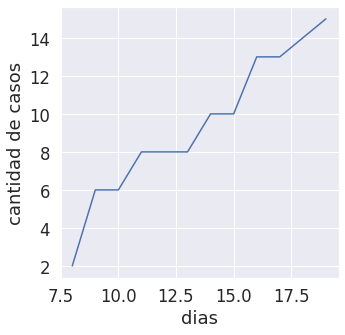

In [143]:
plt.figure(figsize = (5,5))
casos_principio=casos_vietnam[8:20]
dias_principio=dias[8:20]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

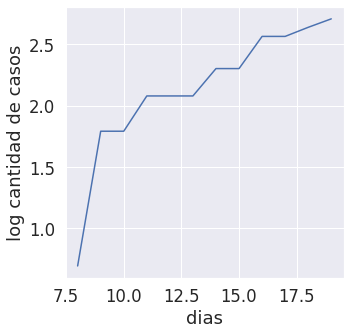

In [144]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [145]:
dias_principio

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [146]:
casos_principio

350     2.0
400     6.0
438     6.0
471     8.0
510     8.0
541     8.0
585    10.0
639    10.0
718    13.0
757    13.0
770    14.0
822    15.0
Name: total_cases, dtype: float64

In [147]:
exponencial

<function __main__.exponencial>

In [148]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([ 0.10613102, -7.0430964 ])

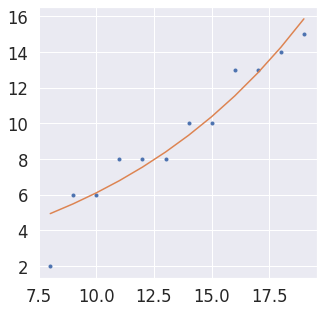

In [149]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

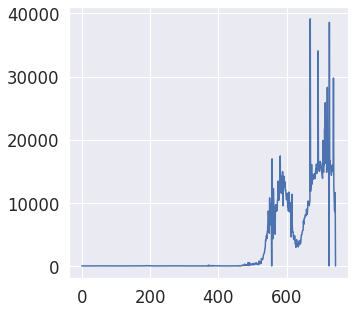

In [150]:
plt.figure(figsize = (5,5))
casos_vietnam=np.array(casos_vietnam)
nuevos_vietnam=casos_nuevos(casos_vietnam)
plt.plot(nuevos_vietnam)

In [151]:
rmse_vietnam = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_vietnam))

1.1913225983491664e+00


In [152]:
t0_vietnam = dias_principio[0]
t_vietnam = dias_principio[-1]
k_vietnam = k
rmse_vietnam = rmse_vietnam

dic_vietnam = {"Pais": "Vietnam", "t0":[t0_vietnam], "t":[t_vietnam], "k": [k_vietnam], "rmse_vietnam":[rmse_vietnam]}
datos_vietnam = pd.DataFrame(data=dic_vietnam)
datos_vietnam

,Pais,t0,t,k,rmse_vietnam
0,Vietnam,8,19,0.106131,1.191323


* **Pais 10: Taiwan**

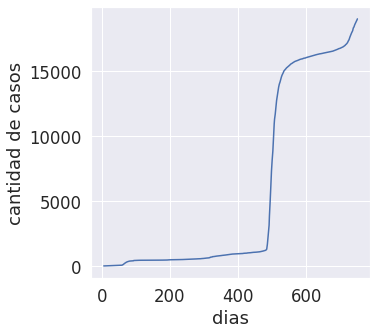

In [153]:
plt.figure(figsize = (5,5))
ind_taiwan=np.where(paises=='Taiwan')
ind_taiwan=ind_taiwan[0]
casos_taiwan=confirmados[ind_taiwan]
dias=np.arange(0,len(casos_taiwan))
plt.plot(dias,casos_taiwan)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

Esta es la curva de **casos totales** de Taiwan. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

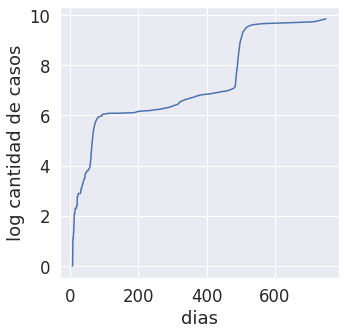

In [154]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_taiwan))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Taiwan, para ver cómo fue el $k$ inicial

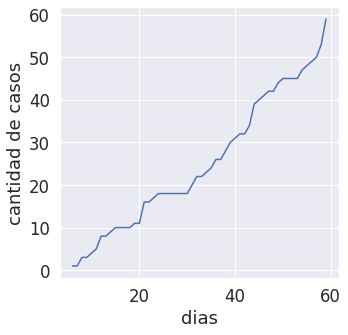

In [155]:
plt.figure(figsize = (5,5))
casos_principio=casos_taiwan[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

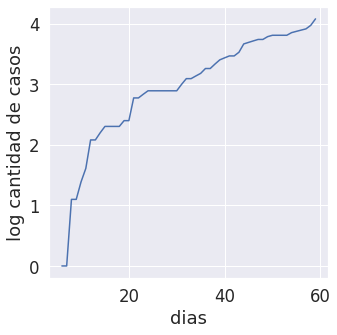

In [156]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

Mejor nos quedamos con lo que sucede entre los días 1 y 35, ya que ese fue el comportamiento más sostenido.

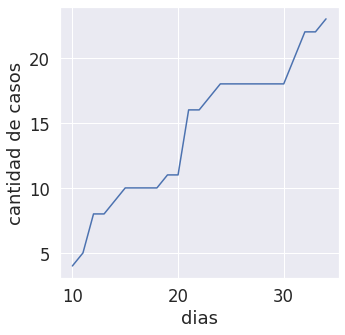

In [157]:
plt.figure(figsize = (5,5))
casos_principio=casos_taiwan[10:35]
dias_principio=dias[10:35]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')
plt.grid(True)

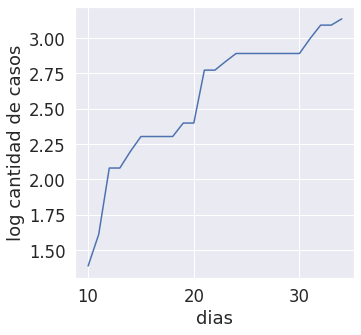

In [158]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')
plt.grid(True)

In [159]:
dias_principio

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34])

In [160]:
casos_principio

204      4.0
223      5.0
253      8.0
266      8.0
306      9.0
360     10.0
390     10.0
444     10.0
452     10.0
527     11.0
560     11.0
615     16.0
665     16.0
690     17.0
759     18.0
797     18.0
843     18.0
880     18.0
948     18.0
967     18.0
1052    18.0
1077    20.0
1144    22.0
1171    22.0
1209    23.0
Name: total_cases, dtype: float64

In [161]:
exponencial

<function __main__.exponencial>

In [162]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=100000)
popt

array([  0.04818143, -32.09689915])

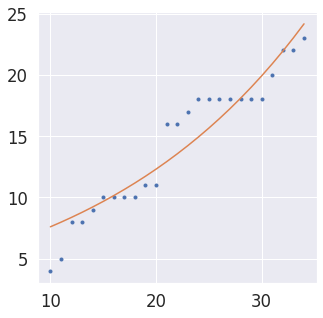

In [163]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

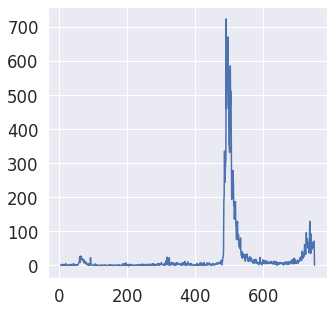

In [164]:
plt.figure(figsize = (5,5))
casos_taiwan=np.array(casos_taiwan)
nuevos_taiwan=casos_nuevos(casos_taiwan)
plt.plot(nuevos_taiwan)

In [165]:
rmse_taiwan = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_taiwan))

3.0373733651441075e+00


In [166]:
t0_taiwan = dias_principio[0]
t_taiwan = dias_principio[-1]
k_taiwan = k
rmse_taiwan = rmse_taiwan

dic_taiwan = {"Pais": "Taiwan", "t0":[t0_taiwan], "t":[t_taiwan], "k": [k_taiwan], "rmse_taiwan":[rmse_taiwan]}
datos_taiwan = pd.DataFrame(data=dic_taiwan)
datos_taiwan

,Pais,t0,t,k,rmse_taiwan
0,Taiwan,10,34,0.048181,3.037373


* **Datos mundiales (World)**

Text(0, 0.5, 'cantidad de casos')

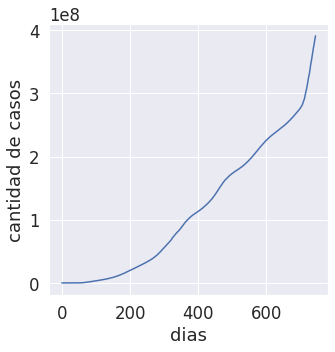

In [167]:
plt.figure(figsize = (5,5))
ind_world=np.where(paises=='World')
ind_world=ind_world[0]
casos_world=confirmados[ind_world]
dias=np.arange(0,len(casos_world))
plt.plot(dias,casos_world)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

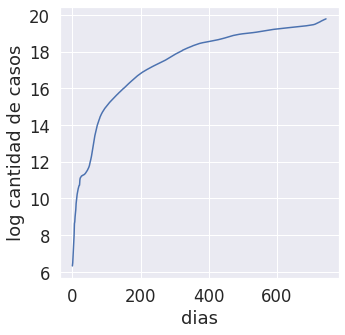

In [168]:
plt.figure(figsize = (5,5))
plt.plot(dias,np.log(casos_world))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Text(0, 0.5, 'cantidad de casos')

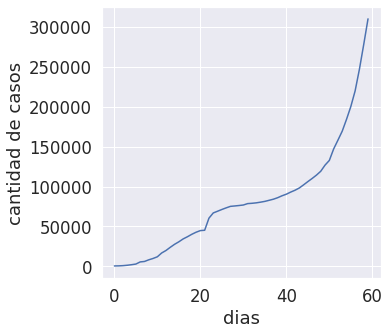

In [169]:
plt.figure(figsize = (5,5))
casos_principio=casos_world[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

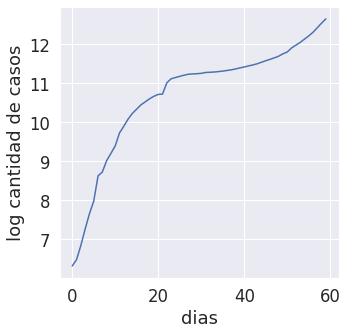

In [170]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 1 y 30, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

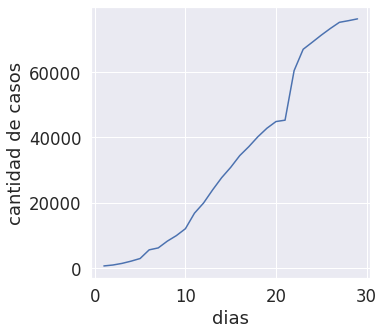

In [171]:
plt.figure(figsize = (5,5))
casos_principio=casos_world[1:30]
dias_principio=dias[1:30]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

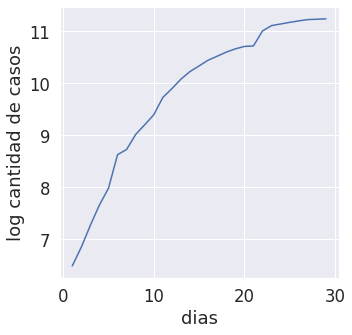

In [172]:
plt.figure(figsize = (5,5))
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [173]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 8.63111387e-02, -1.03369784e+02])

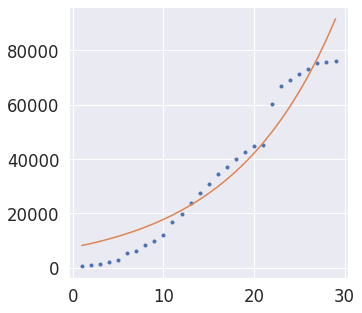

In [174]:
plt.figure(figsize = (5,5))
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

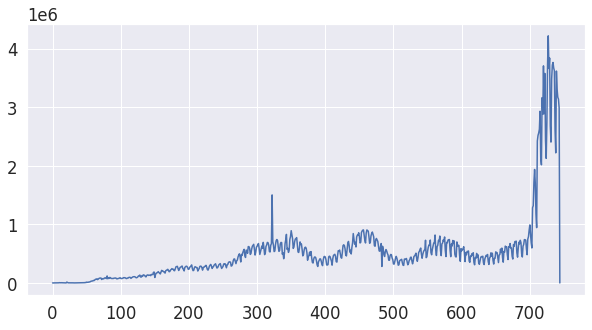

In [175]:
plt.figure(figsize = (10,5))
casos_world=np.array(casos_world)
nuevos_world=casos_nuevos(casos_world)
plt.plot(nuevos_world)

In [176]:
rmse_world = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse_world))

4.770703721493713e+07


In [177]:
t0_world = dias_principio[0]
t_world = dias_principio[-1]
k_world = k
rmse_world = rmse_world

dic_world = {"Pais": "World", "t0":[t0_world], "t":[t_world], "k": [k_world], "rmse_world":[rmse_world]}
datos_world = pd.DataFrame(data=dic_world)
datos_world

,Pais,t0,t,k,rmse_world
0,World,1,29,0.086311,4.770704e+07


In [178]:
resultados_paises = pd.concat([datos_china, datos_india, datos_indonesia, datos_iran, datos_israel, datos_japon, datos_rusia, datos_thailand,
                        datos_taiwan, datos_vietnam, datos_world]
                       )

In [179]:
resultados_paises

,Pais,t0,t,k,rmse_china,rmse,rmse_indonesia,rmse_iran,rmse_irsrael,rmse_japon,rmse_rusia,rmse_thailand,rmse_taiwan,rmse_vietnam,rmse_world
0,China,0,34,0.063863,1.051985e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,India,31,54,0.183721,NaN,241.613349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Indonesia,1,34,0.111893,NaN,NaN,10621.655276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Iran,1,29,0.118248,NaN,NaN,NaN,1.236519e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Israel,2,37,0.228063,NaN,NaN,NaN,NaN,13382.949042,NaN,NaN,NaN,NaN,NaN,NaN
0,Japan,2,34,0.120210,NaN,NaN,NaN,NaN,NaN,28.782937,NaN,NaN,NaN,NaN,NaN
0,Russia,25,59,0.206416,NaN,NaN,NaN,NaN,NaN,NaN,234.528161,NaN,NaN,NaN,NaN
0,Thailand,20,54,0.031601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.566501,NaN,NaN,NaN
0,Taiwan,10,34,0.048181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.037373,NaN,NaN
0,Vietnam,8,19,0.106131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.191323,NaN


2. **Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para k a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de k. Luego compara el modelo con los datos mundiales.**

Se crea una muestra k con tamaño de 10 que  son los 10 paises del norte donde comenzo la pandemia anteriormente calculados 

In [180]:
k = [6.38634508e-02, 0.18372089, 0.20641631, 0.11824802, 0.11189257, 0.22806306, 0.12021023,  3.16006908e-02, 0.10613102, 0.04818143]  # se define datos de muestra

K world = 8.63111387e-02

Se va a realizar un histograma de los datos de la muestra (K) para mirar como es su distribución

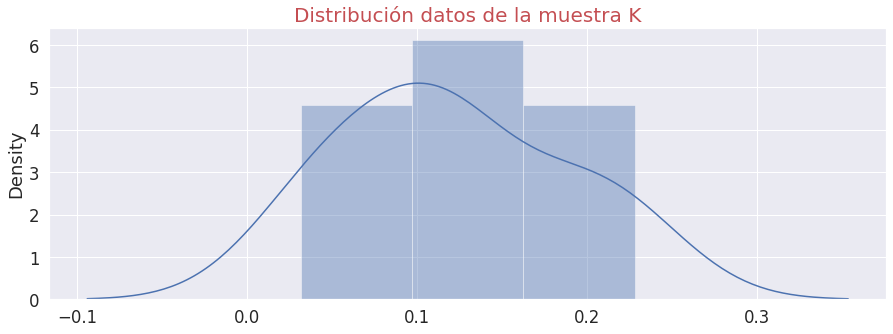

In [181]:
sns.distplot(k, kde = True)
plt.title('Distribución datos de la muestra K', size = 20, color='r')
plt.show()

La representación gráfica muestra que los datos no se distribuyen de forma normal. Esto implica que, la aproximación basada en el teorema del límite central para estimar el error estándar deja de ser buena.

Una alternativa para poder calcular intervalos de confianza es emplear **bootstrapping**.

**Bootstrapping** es una prueba / métrica que usa muestreo aleatorio con reemplazo. Proporciona la medida de precisión(sesgo, varianza, intervalos de confianza, error de predicción, etc.) a las estimaciones de muestra. Permite la estimación de la distribución muestral para la mayoría de las estadísticas utilizando métodos de muestreo aleatorio.

Existen varios métodos para estimar intervalos de confianza mediante el uso de bootstrapping:

* Intervalos basados en distribución normal (normal bootstrap intervals)
* Intervalos basados en percentiles (percentile bootstrap intervals)
* Intervalos basados en distribución Student's (bootstrap Student's t intervals)
* Bias-Corrected and Accelerated Bootstrap Method (BCA)
* Intervalos empíricos (empirical bootstrap intervals)

In [182]:
n = len(k) #Tamaño de la muestra observada

In [183]:
alpha = 0.05 # error que estamos dispuestos a cometer

In [184]:
print('Media:',np.mean(k))
print('Desvio Estandar:',np.std(k))

Media: 0.12183276716000002
Desvio Estandar: 0.06289436756684082


Se va a escoger B=100 (iteraciones) que quiere decir que va a recorrer 100 veces o hacer 100 resampleos y va a sacar una muerta del mismo tamaño del original 

In [185]:
def bootstrap_simplificado(dataset, B=100):
    boots = list()
    for _ in range(B):
        boots.append(np.random.choice(dataset, size=len(dataset)))
    return np.array(boots)

* Primero para sacar el intervalo de confianza se utiliza boostrap 

In [186]:
datos_boots = bootstrap_simplificado(k, 100)

In [187]:
datos_boots.shape

(100, 10)

In [188]:
alpha = 0.05

* Luego se va a sacar la medida de central de cada una de las muestras en este  caso se va a utilizar la media. 

In [189]:
medias = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots)

In [190]:
medias.sort() # se va a ordenar

In [191]:
k_final = medias.mean()
medias.mean()

0.12386488300600001

(array([ 1.,  0.,  1.,  0.,  1.,  4.,  3.,  8.,  7.,  9., 10.,  7.,  8.,
        11.,  4.,  9.,  6.,  6.,  1.,  4.]),
 array([0.06411945, 0.06916103, 0.07420262, 0.0792442 , 0.08428578,
        0.08932736, 0.09436895, 0.09941053, 0.10445211, 0.10949369,
        0.11453528, 0.11957686, 0.12461844, 0.12966002, 0.13470161,
        0.13974319, 0.14478477, 0.14982635, 0.15486794, 0.15990952,
        0.1649511 ]),
 <a list of 20 Patch objects>)

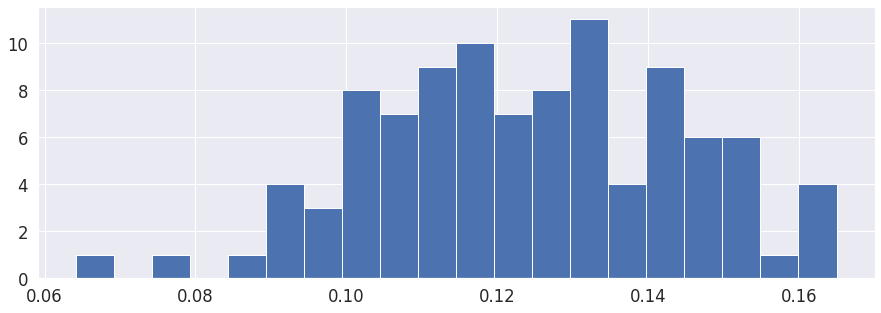

In [192]:
plt.hist(medias, bins=20)

Se va a sacar el intervalo de confianza a partir de los percentiles.

In [193]:
inferior = np.percentile(medias, alpha/2)

In [194]:
superior = np.percentile(medias, (100-alpha/2))

In [195]:
intervalo_confianza = [inferior, superior]

In [196]:
intervalo_confianza

[0.06438041465024999, 0.16491987632574998]

In [197]:
Kworld = 8.63111387e-02

Se puede observar que el Kworld se encuentra dentro del intervalo de confianza, 
existe una probabilidad del 95% de que el intervalo de confianza de [0.08434277566754, 0.18122756414097993] que a partir de los 10 paises del norte que se tomaron donde comenzo la pandemia se puede estimar la evolución mundial de la pandemia, solo hay un 5% de probabilidad de que la evolución mundial de la pandemia esté fuera del intervalo de confianza del 95%

*  **Luego compara el modelo con los datos mundiales.**

In [198]:
rmse = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse))

4.770703721493713e+07


El error del modelo dio 4.770704e+07

Para saber si el modelo dio bien o no se calculo el error de K de varios paises y se comparo con la K mundial que a simple vista pareciera un error muy alto.

El RMSE del modelo dio un error muy alto al compararlo con el de los demas paises  eso debido a que es muy dificil hacer un modelo que se aproxime al **kworld** y que se pueda utilizar para predecir la cantidad de contagios. Aunque el virus es el mismo , las formas de propagarse van a variar en los diferentes paises dependiendo de las medidas que tomaron cada pais (cuarentena, vacunas, tapabocas, detectar grupos de infección y atacarlos rapodamente), la sobrepoblación tambien influyel la pobreza, los servicios de salud no sean propicias,  Esto indica que para poder predecir con una precision considerable la cantidad de contagios hay que tener en cuenta la poblacion de paises bajo las mismas politicas publicas contra el virus, en determinados periodos de tiempo. 
El modelo no da bien ya que el mundo es demasiado variado.

## Parte 2 - Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

Una de las principales aplicaciones de un modelo de regresión logística es clasificar la variable cualitativa en función del valor que tomen los predictores. Dado que la salida de un modelo logístico es una probabilidad, para conseguir la clasificación, es necesario establecer un límite (threshold) a partir del cual se considera que la variable pertenece a uno de los niveles. Por ejemplo en este caso se va asignar una observación al grupo 1 si se cumplio con la medida sanitaria de paises que hicieron cuarentena y al grupo 0 los paises que no realizaron cuarentena.

# Indicadores 

Como política pública se va a elegir **cuarentena**, que paises hicieron cuarentena y cuales paises no hicieron y esta medida como influyo para combatir el covid-19.
Para hablar del éxito de esa política vamos a usar como indicadores: **nuevos casos por millon,  la tasa de reproduccion y  el indice de rigurosidad**

**Stringency_index**, calcula un índice de rigurosidad, el cual es una medida compuesta de nueve métricas de respuesta: 
cierre de escuelas; cierres de lugares de trabajo; cancelación de eventos públicos; restricciones a las reuniones públicas; cierres de transporte público; requisitos para quedarse en casa; campañas de información pública; restricciones a los movimientos internos; y controles de viajes internacionales.

Se va a cargar el archivo que contiene los datos del nombre de cada columna y su descripción.

In [199]:
descripcion=pd.read_csv('/content/gdrive/My Drive/Data_Science_Acamica/Proyectos/owid-covid-codebook.csv')
descripcion

,column,source,category,description
0,iso_code,International Organization for Standardization,Others,ISO 3166-1 alpha-3 – three-letter country codes
1,continent,Our World in Data,Others,Continent of the geographical location
2,location,Our World in Data,Others,Geographical location
3,date,Our World in Data,Others,Date of observation
4,total_cases,COVID-19 Data Repository by the Center for Sys...,Confirmed cases,Total confirmed cases of COVID-19. Counts can ...
...,...,...,...,...
62,human_development_index,United Nations Development Programme (UNDP),Others,A composite index measuring average achievemen...
63,excess_mortality,"Human Mortality Database (2021), World Mortali...",Excess mortality,Percentage difference between the reported num...
64,excess_mortality_cumulative,"Human Mortality Database (2021), World Mortali...",Excess mortality,Percentage difference between the cumulative n...
65,excess_mortality_cumulative_absolute,"Human Mortality Database (2021), World Mortali...",Excess mortality,Cumulative difference between the reported num...


In [200]:
descripcion.set_index('column', inplace=True)

In [201]:
descripcion

,source,category,description
column,,,
iso_code,International Organization for Standardization,Others,ISO 3166-1 alpha-3 – three-letter country codes
continent,Our World in Data,Others,Continent of the geographical location
location,Our World in Data,Others,Geographical location
date,Our World in Data,Others,Date of observation
total_cases,COVID-19 Data Repository by the Center for Sys...,Confirmed cases,Total confirmed cases of COVID-19. Counts can ...
...,...,...,...
human_development_index,United Nations Development Programme (UNDP),Others,A composite index measuring average achievemen...
excess_mortality,"Human Mortality Database (2021), World Mortali...",Excess mortality,Percentage difference between the reported num...
excess_mortality_cumulative,"Human Mortality Database (2021), World Mortali...",Excess mortality,Percentage difference between the cumulative n...


In [202]:
descripcion.description.reproduction_rate

'Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database'

In [203]:
descripcion.description.new_cases_per_million

'New confirmed cases of COVID-19 per 1,000,000 people. Counts can include probable cases, where reported.'

In [204]:
descripcion.description.new_deaths_per_million

'New deaths attributed to COVID-19 per 1,000,000 people. Counts can include probable deaths, where reported.'

In [205]:
descripcion.description.stringency_index

'Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)'

Ademas se quiere saber cuantas muertes hubieron por casos

In [206]:
datos['per_death_to_case'] = datos.new_cases_per_million / datos.new_deaths_per_million
datos

,index,iso_code,continent,pais,fecha,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,per_death_to_case
0,0,ARG,South America,Argentina,2020-01-01,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.00,76.67,0.845,NaN,NaN,NaN,NaN,NaN
1,1,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,...,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN,NaN
2,2,PER,South America,Peru,2020-01-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.60,76.74,0.777,NaN,NaN,NaN,NaN,NaN
3,3,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,...,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN,NaN
4,4,ARG,South America,Argentina,2020-01-02,NaN,NaN,NaN,NaN,NaN,...,27.7,NaN,5.00,76.67,0.845,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159548,159548,SPM,North America,Saint Pierre and Miquelon,2022-02-04,964.0,11.0,17.857,1.0,0.0,...,NaN,NaN,NaN,81.07,NaN,NaN,NaN,NaN,NaN,inf
159549,159549,BRA,South America,Brazil,2022-02-04,26326454.0,218560.0,182264.714,631265.0,964.0,...,17.9,NaN,2.20,75.88,0.765,NaN,NaN,NaN,NaN,226.712542
159550,159550,LCA,North America,Saint Lucia,2022-02-04,21399.0,NaN,NaN,333.0,0.0,...,NaN,87.202,1.30,76.20,0.759,NaN,NaN,NaN,NaN,NaN
159551,159551,BEL,Europe,Belgium,2022-02-04,3296038.0,28382.0,34301.857,29227.0,42.0,...,31.4,NaN,5.64,81.63,0.931,NaN,NaN,NaN,NaN,675.691775


Primero se van a realizar graficas de cada continente con los 3 indicadores para mirar como fue su comportamiento y luego se va a trabajar con los 10 paises que se escogieron donde 5 implementaron la medida sanitaria en este caso la cuarentena y 5 no implementaron la medida sanitaria.

In [207]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [208]:
trace1 = go.Scatter(
                    x = datos[(datos['continent']=='Asia')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='Asia')].groupby(['fecha','continent'])['new_cases_per_million'].sum(),
                    mode = "lines",
                    name = "Asia",
                    marker = dict(color = 'green'),
)

trace2 = go.Scatter(
                    x = datos[(datos['continent']=='Europe')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='Europe')].groupby(['fecha','continent'])['new_cases_per_million'].sum(),
                    mode = "lines",
                    name = "Europe",
                    marker = dict(color = 'red'),
)

trace3 = go.Scatter(
                    x = datos[(datos['continent']=='Africa')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='Africa')].groupby(['fecha','continent'])['new_cases_per_million'].sum(),
                    mode = "lines",
                    name = "Africa",
                    marker = dict(color = 'blue'),
                    #text= df.university_name
)

trace4 = go.Scatter(
                    x = datos[(datos['continent']=='North America')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='North America')].groupby(['fecha','continent'])['new_cases_per_million'].sum(),
                    mode = "lines",
                    name = "North America",
                    marker = dict(color = 'black'),
)

trace5 = go.Scatter(
                    x = datos[(datos['continent']=='South America')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='South America')].groupby(['fecha','continent'])['new_cases_per_million'].sum(),
                    mode = "lines",
                    name = "South America",
                    marker = dict(color = 'brown'),
)

data = [trace1,trace2,trace3,trace4,trace5]
layout = dict(title = 'NewCases Per Millon',
              xaxis= dict(title= '# cases day by day',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

En las graficas se puede observar que se presentan unos picos en el continente de Norte America y Sur America de nuevos casos por millon mientras que en los otros continentes se mantiene mas estable.

In [209]:
trace1 = go.Scatter(
                    x = datos[(datos['continent']=='Asia')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='Asia')].groupby(['fecha','continent'])['reproduction_rate'].sum(),
                    mode = "lines",
                    name = "Asia",
                    marker = dict(color = 'green'),
)

trace2 = go.Scatter(
                    x = datos[(datos['continent']=='Europe')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='Europe')].groupby(['fecha','continent'])['reproduction_rate'].sum(),
                    mode = "lines",
                    name = "Europe",
                    marker = dict(color = 'red'),
)

trace3 = go.Scatter(
                    x = datos[(datos['continent']=='Africa')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='Africa')].groupby(['fecha','continent'])['reproduction_rate'].sum(),
                    mode = "lines",
                    name = "Africa",
                    marker = dict(color = 'blue'),
                    #text= df.university_name
)

trace4 = go.Scatter(
                    x = datos[(datos['continent']=='North America')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='North America')].groupby(['fecha','continent'])['reproduction_rate'].sum(),
                    mode = "lines",
                    name = "North America",
                    marker = dict(color = 'black'),
)

trace5 = go.Scatter(
                    x = datos[(datos['continent']=='South America')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='South America')].groupby(['fecha','continent'])['new_cases_per_million'].sum(),
                    mode = "lines",
                    name = "South America",
                    marker = dict(color = 'brown'),
)

data = [trace1,trace2,trace3,trace4,trace5]
layout = dict(title = 'Reproduction rate',
              xaxis= dict(title= '# cases day by day',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

En estas graficas se puede ver que el continente de Sur America presenta grandes fluctuaciones sobre la reproducción del virus mientras que en los otros continentes es estatico, esto se debe a que en sur america fueron menos estrictas las medidas para combatir el covid ya que hay mas trabajos informales donde la economia no se podia parar y se presentaron menos ayudas por parte del gobierno.

In [210]:
trace1 = go.Scatter(
                    x = datos[(datos['continent']=='Asia')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='Asia')].groupby(['fecha','continent'])['stringency_index'].sum(),
                    mode = "lines",
                    name = "Asia",
                    marker = dict(color = 'green'),
)

trace2 = go.Scatter(
                    x = datos[(datos['continent']=='Europe')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='Europe')].groupby(['fecha','continent'])['stringency_index'].sum(),
                    mode = "lines",
                    name = "Europe",
                    marker = dict(color = 'red'),
)

trace3 = go.Scatter(
                    x = datos[(datos['continent']=='Africa')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='Africa')].groupby(['fecha','continent'])['stringency_index'].sum(),
                    mode = "lines",
                    name = "Africa",
                    marker = dict(color = 'blue'),
                    #text= df.university_name
)

trace4 = go.Scatter(
                    x = datos[(datos['continent']=='North America')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='North America')].groupby(['fecha','continent'])['stringency_index'].sum(),
                    mode = "lines",
                    name = "North America",
                    marker = dict(color = 'black'),
)

trace5 = go.Scatter(
                    x = datos[(datos['continent']=='South America')].groupby(['fecha','continent'])['fecha'].apply(lambda x: np.unique(x)[0]),
                    y = datos[(datos['continent']=='South America')].groupby(['fecha','continent'])['stringency_index'].sum(),
                    mode = "lines",
                    name = "South America",
                    marker = dict(color = 'brown'),
)

data = [trace1,trace2,trace3,trace4,trace5]
layout = dict(title = 'stringency index',
              xaxis= dict(title= '# cases day by day',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

Se puede observar en la grafica que en el intervalo de tiempo de abril a julio  los continentes de Africa, Asia y Europa presentaron un alto indice de rigurosidad eso debido a todas las medidas que se tomaron para frenar la propagación del covid, con respecto a Norte Armerica y sur America presentaron un indice de rigurosidad muy bajo que se sostubo durante toda la pandemia.

Ahora se va a escoger:
**PAISES QUE HICIERON CUARENTENA**
* **China**: a pesar de su gran población establecio obligatorios protocolos de aislamiento y centros de cuarentena para personas contagiadas y personas que estuvieron en contacto con ellas. 
* **Nueva Zelanda**: al ser una isla facilito su control,  cerro sus fronteras. 
en marzo para eliminar el peligroy no permitirque llegaran personas de otros paises contagiadas, en junio declaro que no tenia casos de covid y con la tasa mas baja de muertes.
* **Australia:** fue otro país considerado un ejemplo en su respuesta a la pandemia.
El 1 de febrero de 2020 cerro sus fronteras a los visitantes extranjeros que recientemente estuvieron en China. A medida que el virus se propagó, el país prohibió las entradas de Irán, Corea del Sur e Italia a principios de marzo, antes de cerrar sus fronteras a todos las personas no ciudadanas y no residentes el 19 de marzo, otra medida que tomo fue reducir el uso de las transferencias electronicas de dinero, ya que al principio se pensaba que se trasmitia el virus por medio del contacto con el dinero. 
* En A**rgentina y Colombia**, ambos países hubo aislamiento social obligatorio, los gobiernos permiten a la población salir a pasear o hacer actividad física una hora al día.

**PAISES QUE NO HICIERON CUARENTENA**
* **Estados unidos:** ha tenido uno de las peores respuestas a la pandemia, habian mas casos en 3 minutos que Taiwan en un año.
* **Japon**: El país nunca implementó una cuarentena obligatoria (lo cual no está permitido por la ley), pero vio a sus ciudadanos cumplir cabalmente el estado de emergencia decretado por el primer ministro Shinzo Abe. Sin embargo tuvo mucho éxito en contener la propagación del covid-19 al enfocarse en grupos de brotes, es decir, personas que infectan a las otras personas. Se les ha hecho pruebas y se les ha aislado. 
* **Suecia**: su estrategia de mitigación del coronavirus puede parecer algo inusual. Mientras diversos países han apostado por los cierres de fronteras y la cuarentena, Suecia ha mantenido abiertas sus escuelas, gimnasios, restaurantes y bares. Pero ha prohibido concentraciones de más de 50 personas. Además, el gobierno le ha pedido a su población ser responsable y seguir el distanciamiento social. 
Sin embargo, parte del éxito de esta estrategia se debe a que esta nación posee uno de los mejores sistemas de atención médica en el mundo.
* **Brasil**: ha hecho recomendaciones para que se mantenga el distanciamiento social pero no ha impuesto restricciones, una medida que ha resultado polémica.
* **Nicaragua**:  es el país de la región que menos medidas ha tomado para hacer frente al coronavirus.
Varias organizaciones internacionales alertaron de las consecuencias que podría tener esta falta de medidas en un país que ya tiene factores de riesgo adicionales, como la ausencia de agua potable permanente o el hacinamiento, entre otros.

In [211]:
paises = ["China", "United States", "New Zealand","Australia","Japan", "Sweden","Nicaragua", "Argentina", "Colombia", "Brazil", "Russia"]

In [212]:
covid =pd.read_csv('/content/gdrive/My Drive/Data_Science_Acamica/Proyectos/covid-stringency-index.csv')
covid

,Entity,Code,Day,stringency_index
0,Afghanistan,AFG,2020-01-21,0.0
1,Afghanistan,AFG,2020-01-22,0.0
2,Afghanistan,AFG,2020-01-23,0.0
3,Afghanistan,AFG,2020-01-24,0.0
4,Afghanistan,AFG,2020-01-25,0.0
...,...,...,...,...
145130,Zimbabwe,ZWE,2022-03-17,53.7
145131,Zimbabwe,ZWE,2022-03-18,53.7
145132,Zimbabwe,ZWE,2022-03-19,53.7
145133,Zimbabwe,ZWE,2022-03-20,53.7


In [213]:
datos_paises = datos[(datos.pais.isin(paises)) & (datos.fecha < "2022-05-01")]
datos_paises = datos[datos.pais.isin(paises)]
datos_paises = datos_paises[["pais","fecha", "new_cases_per_million", "reproduction_rate","stringency_index"]]
datos_paises.fecha = pd.to_datetime(datos_paises.fecha)
datos_paises

,pais,fecha,new_cases_per_million,reproduction_rate,stringency_index
0,Argentina,2020-01-01,NaN,NaN,0.0
4,Argentina,2020-01-02,NaN,NaN,0.0
7,Argentina,2020-01-03,NaN,NaN,0.0
10,Argentina,2020-01-04,NaN,NaN,0.0
16,Argentina,2020-01-05,NaN,NaN,0.0
...,...,...,...,...,...
159455,Sweden,2022-02-04,2768.559,NaN,NaN
159484,United States,2022-02-04,1115.741,NaN,NaN
159491,Argentina,2022-02-04,879.142,NaN,NaN
159498,Russia,2022-02-04,1144.231,NaN,NaN


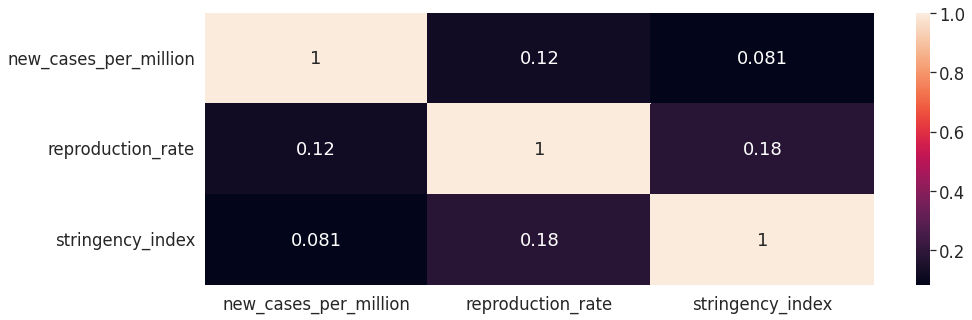

In [214]:
# Analisis de Correlacion entre los indicadores 

corr_df = datos_paises.corr()
sns.heatmap(corr_df, annot=True)

# Exploración de datos

No se van a tener en cuenta todas las columnas para el trabajo de exploración y análisis, ya que que nos vamos a enfocar en analizar la cantidad de contagios y si las medidas sanitarias en este caso paises que realizaron cuarentena logro disminuir la cantidad de contagios hasta un decaimiento dado por la inmunidad. Las columnas a utilizar van a ser seleccionadas y colocadas en una lista que luego fue asignada a una variable **selected_columns**.

In [215]:
selected_columns = [
    'continent', 'pais', 'fecha', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths',
    'reproduction_rate', 'population', 'total_vaccinations','people_vaccinated', 'people_fully_vaccinated', 'median_age', 'aged_65_older', 
    'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million','new_deaths_per_million',  'stringency_index'   
]

Ahora el nuevo dataframe llamado datos paso de 67 columnas a tener 22 columnas.

In [216]:
datos = datos[selected_columns]

In [217]:
datos.head()

,continent,pais,fecha,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,stringency_index
0,South America,Argentina,2020-01-01,NaN,NaN,NaN,NaN,NaN,45605823.0,NaN,NaN,NaN,31.9,11.198,NaN,NaN,NaN,NaN,0.0
1,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,130262220.0,NaN,NaN,NaN,29.3,6.857,NaN,NaN,NaN,NaN,0.0
2,South America,Peru,2020-01-01,NaN,NaN,NaN,NaN,NaN,33359415.0,NaN,NaN,NaN,29.1,7.151,NaN,NaN,NaN,NaN,0.0
3,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,130262220.0,NaN,NaN,NaN,29.3,6.857,NaN,NaN,NaN,NaN,0.0
4,South America,Argentina,2020-01-02,NaN,NaN,NaN,NaN,NaN,45605823.0,NaN,NaN,NaN,31.9,11.198,NaN,NaN,NaN,NaN,0.0


In [218]:
datos.shape

(159553, 19)

In [219]:
datos.columns

Index(['continent', 'pais', 'fecha', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'reproduction_rate', 'population',
       'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'median_age', 'aged_65_older', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'stringency_index'],
      dtype='object')

* Vamos a analizar la eficacia de la medida sanitaria para este caso cuarentena que hicieron los paises y este con influyo para combatir el covid-19, para esto nos vamos a quedar con algunos paises que implementaron la medida y otros que no.
Se va a filtrar por los 10 paises donde 5 de ellos aplicacion la medida sanitaria (Cuarentena), y 5 de ellos no la aplicaron.

In [220]:
datos = datos[datos.pais.isin(["China", "United States", "New Zealand","Australia","Japan", "Sweden","Nicaragua", "Argentina", "Colombia", "Brazil"])]

Al utilizar la función unique nos damos cuenta que efectivamente se filtro por los 10 paises de interes.

In [221]:
print(datos['pais'].unique())

['Argentina' 'China' 'Japan' 'United States' 'Australia' 'Sweden' 'Brazil'
 'New Zealand' 'Colombia' 'Nicaragua']


Ahora se va a determinar los paises que NO hicieron cuarentena el cual se va a representar con un cero y 1 los paises que SI hicieron cuarentena

In [222]:
datos['cuarentena'] = np.where((datos['pais'] =='Japan')|(datos['pais'] =='United States')|(datos['pais'] =='Sweden')|(datos['pais'] =='Brazil')|(datos['pais'] =='Nicaragua'),1,0)

In [223]:
datos.head()

,continent,pais,fecha,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,stringency_index,cuarentena
0,South America,Argentina,2020-01-01,NaN,NaN,NaN,NaN,NaN,45605823.0,NaN,NaN,NaN,31.9,11.198,NaN,NaN,NaN,NaN,0.0,0
4,South America,Argentina,2020-01-02,NaN,NaN,NaN,NaN,NaN,45605823.0,NaN,NaN,NaN,31.9,11.198,NaN,NaN,NaN,NaN,0.0,0
7,South America,Argentina,2020-01-03,NaN,NaN,NaN,NaN,NaN,45605823.0,NaN,NaN,NaN,31.9,11.198,NaN,NaN,NaN,NaN,0.0,0
10,South America,Argentina,2020-01-04,NaN,NaN,NaN,NaN,NaN,45605823.0,NaN,NaN,NaN,31.9,11.198,NaN,NaN,NaN,NaN,0.0,0
16,South America,Argentina,2020-01-05,NaN,NaN,NaN,NaN,NaN,45605823.0,NaN,NaN,NaN,31.9,11.198,NaN,NaN,NaN,NaN,0.0,0


In [224]:
# Número de obsercaciones por clase
datos.cuarentena.value_counts().sort_index()

0    3661
1    3623
Name: cuarentena, dtype: int64

Ahora vamos a tratar los **outliers** debido a que estos datos distorsionan los resultados, para luego imputar los valores faltantes usando medidas de tendencia central debido a que estas medidas de tendencia central pueden ser sensibles a outliers, por lo que la imputación de valores faltantes puede verse afectada se modifica la distribución de los datos.

Vamos a ver cómo es la distribución de la variables realizando boxplots para cada una de ellas.

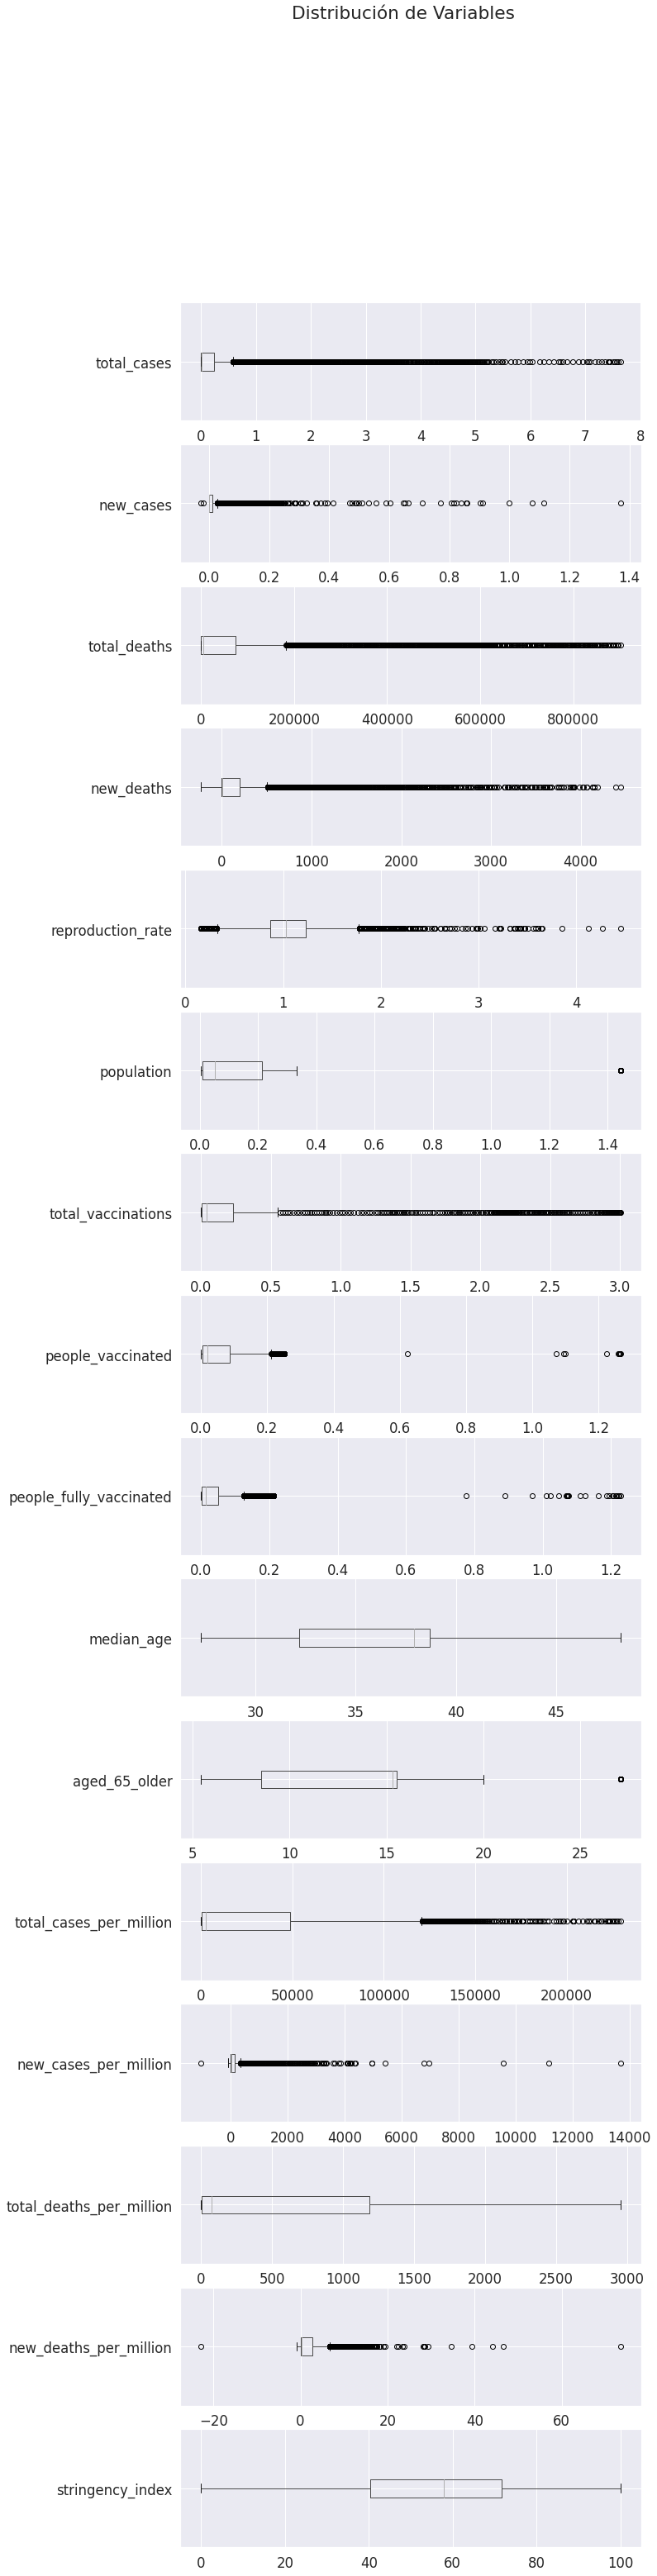

In [225]:
plt.rcParams["figure.figsize"] = (10, 50)
df_num= datos.drop(columns=['continent', 'pais', 'fecha', 'cuarentena'])
fig, axs = plt.subplots(16)
fig.suptitle('Distribución de Variables')
for i,el in enumerate(list(df_num.columns.values)[:]):
    a = datos.boxplot(el, ax=axs.flatten()[i],vert=False)

Se observa la presencia de valores atípicos, donde en algunas variables ni siquiera es posible distinguir una distribución de forma clara.

Se va a utilizar el método describe() para darnos la información estadística básica.

In [226]:
datos.describe()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,stringency_index,cuarentena
count,7.222000e+03,7.218000e+03,7010.000000,7009.000000,6893.000000,7.284000e+03,2.815000e+03,2.415000e+03,2.428000e+03,7284.000000,7284.000000,7222.000000,7218.000000,7010.000000,7009.000000,7209.000000,7284.000000
mean,4.142797e+06,1.736010e+04,88615.867618,261.772150,1.061544,2.300240e+08,2.767844e+08,5.792434e+07,5.131631e+07,36.779393,13.775775,29953.859286,140.791254,635.896748,1.845222,53.860295,0.497392
std,9.935780e+06,5.891426e+04,183323.342440,589.045689,0.395554,4.224026e+08,6.115429e+08,1.006956e+08,1.198013e+08,5.482991,6.104120,44613.164563,444.870613,876.375322,3.361328,24.068450,0.500028
min,1.000000e+00,-2.685600e+04,1.000000,-232.000000,0.160000,5.126300e+06,0.000000e+00,0.000000e+00,1.000000e+00,27.300000,5.445000,0.003000,-1041.406000,0.003000,-22.834000,0.000000,0.000000
25%,1.294400e+04,1.000000e+01,286.250000,0.000000,0.870000,1.016016e+07,6.690928e+06,3.674320e+06,1.486310e+06,32.200000,8.552000,373.807750,0.071000,5.267000,0.000000,40.280000,0.000000
50%,9.963800e+04,5.410000e+02,4636.000000,9.000000,1.030000,5.126584e+07,4.125139e+07,1.975830e+07,1.290009e+07,37.900000,15.322000,2705.846000,14.069500,71.279500,0.195000,57.870000,0.000000
75%,2.336114e+06,1.086000e+04,73350.750000,202.000000,1.230000,2.139934e+08,2.299537e+08,8.713272e+07,5.075598e+07,38.700000,15.504000,48573.553000,135.514500,1184.596750,2.675000,71.760000,1.000000
max,7.635404e+07,1.369637e+06,901391.000000,4442.000000,4.450000,1.444216e+09,3.002896e+09,1.266070e+09,1.227387e+09,48.200000,27.049000,229349.903000,13679.412000,2949.927000,73.477000,100.000000,1.000000


Se puede observar que las variable **new_cases**, **nuevas muertes**,   **reproduction_rate**, **new_cases_per_million**, **new_deaths_per_million**, el valor minimo es negativo el cual no tiene sentido por lo tanto debe eliminarse.

In [227]:
descripcion.description.new_cases

'New confirmed cases of COVID-19. Counts can include probable cases, where reported.'

In [228]:
descripcion.description.new_deaths

'New deaths attributed to COVID-19. Counts can include probable deaths, where reported.'

In [229]:
descripcion.description.reproduction_rate

'Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database'

In [230]:
mask_1 = datos.new_cases > 0
datos= datos[mask_1]

In [231]:
mask_2 = datos.new_deaths > 0
datos= datos[mask_2]

In [232]:
mask_3 = datos.reproduction_rate > 0
datos= datos[mask_3]

In [233]:
mask_4 = datos.new_cases_per_million > 0
datos= datos[mask_4]

In [234]:
mask_5 = datos.new_deaths_per_million > 0
datos= datos[mask_5]

In [235]:
datos.describe()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,stringency_index,cuarentena
count,4.289000e+03,4.289000e+03,4289.000000,4289.000000,4289.000000,4.289000e+03,1.892000e+03,1.812000e+03,1.825000e+03,4289.000000,4289.000000,4289.000000,4289.000000,4289.000000,4289.000000,4273.000000,4289.000000
mean,6.762765e+06,2.838389e+04,140900.586151,422.788529,1.097163,1.545149e+08,1.207463e+08,6.828141e+07,5.229133e+07,37.124365,14.379378,43709.296006,220.551349,934.358464,2.983157,61.610889,0.580555
std,1.195258e+07,7.327646e+04,215587.809998,698.547111,0.390852,2.145761e+08,1.475914e+08,7.492369e+07,6.433782e+07,5.692694,6.598783,47260.257809,515.943221,949.707024,3.840855,17.398385,0.493526
min,1.580000e+02,1.000000e+00,1.000000,1.000000,0.170000,5.126300e+06,2.000000e+00,2.000000e+00,3.500000e+01,27.300000,5.445000,0.442000,0.002000,0.005000,0.001000,0.000000,0.000000
25%,1.091660e+05,1.149000e+03,2941.000000,15.000000,0.900000,4.560582e+07,1.523687e+07,1.117266e+07,4.702964e+06,32.200000,8.552000,2550.620000,23.330000,57.302000,0.310000,49.540000,0.000000
50%,1.597089e+06,6.952000e+03,34223.000000,112.000000,1.040000,5.126584e+07,4.917171e+07,2.979523e+07,2.070617e+07,37.900000,11.198000,21396.544000,89.968000,598.576000,1.575000,63.430000,1.000000
75%,5.354440e+06,2.764500e+04,134079.000000,503.000000,1.220000,2.139934e+08,1.971428e+08,1.237018e+08,8.910131e+07,38.700000,15.504000,90791.269000,227.343000,1698.520000,4.408000,74.540000,1.000000
max,7.499287e+07,1.369637e+06,887824.000000,4442.000000,4.450000,1.444216e+09,1.524897e+09,2.505118e+08,2.114697e+08,48.200000,27.049000,225261.266000,13679.412000,2932.749000,73.477000,100.000000,1.000000


La falta de datos es quizás el rasgo más común de los datos impuros. Estos valores suelen tomar la forma de NaN o None.
Veamos en primer lugar cuántos valores faltantes tiene cada atributo.

In [236]:
print('Valores faltantes por columnas:')
datos.isna().sum().sort_values(ascending=False)

Valores faltantes por columnas:


people_vaccinated           2477
people_fully_vaccinated     2464
total_vaccinations          2397
stringency_index              16
new_deaths_per_million         0
total_deaths_per_million       0
new_cases_per_million          0
total_cases_per_million        0
aged_65_older                  0
median_age                     0
continent                      0
pais                           0
population                     0
reproduction_rate              0
new_deaths                     0
total_deaths                   0
new_cases                      0
total_cases                    0
fecha                          0
cuarentena                     0
dtype: int64

In [237]:
print('Porcentaje de valores faltantes por columnas:')
datos.isna().mean().sort_values(ascending=False)*100

Porcentaje de valores faltantes por columnas:


people_vaccinated           57.752390
people_fully_vaccinated     57.449289
total_vaccinations          55.887153
stringency_index             0.373047
new_deaths_per_million       0.000000
total_deaths_per_million     0.000000
new_cases_per_million        0.000000
total_cases_per_million      0.000000
aged_65_older                0.000000
median_age                   0.000000
continent                    0.000000
pais                         0.000000
population                   0.000000
reproduction_rate            0.000000
new_deaths                   0.000000
total_deaths                 0.000000
new_cases                    0.000000
total_cases                  0.000000
fecha                        0.000000
cuarentena                   0.000000
dtype: float64

La falta de datos es quizás el rasgo más común de los datos impuros. Estos valores suelen tomar la forma de NaN o None. Se va a  tratar los datos faltantes debido a que la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas.

Como podemos observar hay algunas columnas que tienen mas del 60% de valores faltantes ya que por ejemplo en el 2020 todavia no habian vacunas y  se empezaron aplicar desde el 2021.

In [238]:
datos=datos.drop(columns=['people_fully_vaccinated', 'people_vaccinated', 'total_vaccinations'])

In [239]:
from sklearn.impute import SimpleImputer
imp_median  = SimpleImputer(missing_values=np.nan, strategy='mean')

In [240]:
aged_65_older_pais  = datos[["aged_65_older","pais"]].groupby("pais").agg(pd.Series.mean)
continent_pais  = datos[["continent","pais"]].groupby("pais").agg(pd.Series.mean)
median_age_pais  = datos[["median_age","pais"]].groupby("pais").agg(pd.Series.mean)
stringency_index_pais  = datos[["stringency_index","pais"]].groupby("pais").agg(pd.Series.mean)
datos =datos.set_index("pais")
datos.aged_65_older.fillna(aged_65_older_pais.to_dict()["aged_65_older"],inplace=True)
datos.continent.fillna(continent_pais.to_dict()["continent"],inplace=True)
datos.median_age.fillna(median_age_pais.to_dict()["median_age"],inplace=True)
datos.stringency_index.fillna(stringency_index_pais.to_dict()["stringency_index"],inplace=True)
datos = datos.reset_index()
datos.head()

,pais,continent,fecha,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,stringency_index,cuarentena
0,China,Asia,2020-01-23,639.0,92.0,18.0,1.0,3.06,1.444216e+09,38.7,10.641,0.442,0.064,0.012,0.001,44.91,0
1,China,Asia,2020-01-24,916.0,277.0,26.0,8.0,3.22,1.444216e+09,38.7,10.641,0.634,0.192,0.018,0.006,44.91,0
2,China,Asia,2020-01-25,1399.0,483.0,42.0,16.0,3.37,1.444216e+09,38.7,10.641,0.969,0.334,0.029,0.011,47.69,0
3,China,Asia,2020-01-26,2062.0,663.0,56.0,14.0,3.43,1.444216e+09,38.7,10.641,1.428,0.459,0.039,0.010,69.91,0
4,China,Asia,2020-01-27,2863.0,801.0,82.0,26.0,3.47,1.444216e+09,38.7,10.641,1.982,0.555,0.057,0.018,69.91,0


In [241]:
print('Porcentaje de valores faltantes por columnas:')
datos.isna().mean().sort_values(ascending=False)*100

Porcentaje de valores faltantes por columnas:


pais                        0.0
median_age                  0.0
stringency_index            0.0
new_deaths_per_million      0.0
total_deaths_per_million    0.0
new_cases_per_million       0.0
total_cases_per_million     0.0
aged_65_older               0.0
population                  0.0
continent                   0.0
reproduction_rate           0.0
new_deaths                  0.0
total_deaths                0.0
new_cases                   0.0
total_cases                 0.0
fecha                       0.0
cuarentena                  0.0
dtype: float64

Como se puede observar ya no existe ningún dato faltante. 

# **Encoding**

Vamos a utilizar encoding porque Machine Learning solo utiliza valores numéricos, tipo de datos flotantes o enteros. Sin embargo, el dataset contiene variables categoricas de tipo nominal (continent, pais), por lo tanto se hace necesario transformarlo en numérico. Este proceso toma variables categóricas y las convierte en variables binarias con el objetivo de incluirlas en los modelos 

In [242]:
datos = pd.get_dummies(datos, columns=['pais'])
datos.head()

,continent,fecha,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,...,pais_Argentina,pais_Australia,pais_Brazil,pais_China,pais_Colombia,pais_Japan,pais_New Zealand,pais_Nicaragua,pais_Sweden,pais_United States
0,Asia,2020-01-23,639.0,92.0,18.0,1.0,3.06,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0
1,Asia,2020-01-24,916.0,277.0,26.0,8.0,3.22,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0
2,Asia,2020-01-25,1399.0,483.0,42.0,16.0,3.37,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0
3,Asia,2020-01-26,2062.0,663.0,56.0,14.0,3.43,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0
4,Asia,2020-01-27,2863.0,801.0,82.0,26.0,3.47,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0


In [243]:
datos.shape

(4289, 26)

In [244]:
datos.columns

Index(['continent', 'fecha', 'total_cases', 'new_cases', 'total_deaths',
       'new_deaths', 'reproduction_rate', 'population', 'median_age',
       'aged_65_older', 'total_cases_per_million', 'new_cases_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'stringency_index', 'cuarentena', 'pais_Argentina', 'pais_Australia',
       'pais_Brazil', 'pais_China', 'pais_Colombia', 'pais_Japan',
       'pais_New Zealand', 'pais_Nicaragua', 'pais_Sweden',
       'pais_United States'],
      dtype='object')

Se puede observar que el número de columnas aumentaron cuando se paso todas las variables categoricas a binarias.

# **Escalado de datos**

Se va a realizar escalado de datos porque cuando los predictores son numéricos, la escala en la que se miden, así como la magnitud de su varianza pueden influir en gran medida en el modelo. Algunos algoritmos de machine learning que involucra distancias como es para regresion el cual es sensible a esto, de forma que, si no se igualan de alguna forma los predictores, aquellos que se midan en una escala mayor van a tener mas peso y dominarán el modelo aunque no sean los que más relación tienen con la variable respuesta.

In [245]:
datos.head()

,continent,fecha,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,...,pais_Argentina,pais_Australia,pais_Brazil,pais_China,pais_Colombia,pais_Japan,pais_New Zealand,pais_Nicaragua,pais_Sweden,pais_United States
0,Asia,2020-01-23,639.0,92.0,18.0,1.0,3.06,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0
1,Asia,2020-01-24,916.0,277.0,26.0,8.0,3.22,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0
2,Asia,2020-01-25,1399.0,483.0,42.0,16.0,3.37,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0
3,Asia,2020-01-26,2062.0,663.0,56.0,14.0,3.43,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0
4,Asia,2020-01-27,2863.0,801.0,82.0,26.0,3.47,1.444216e+09,38.7,10.641,...,0,0,0,1,0,0,0,0,0,0


In [246]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()

In [247]:
data_escalado = datos.copy()

No se tiene en cuenta en el escalado la variable a predecir en este caso **cuarentena** ya que me  afecta en la interpretabilidad, ya que el error va a dar mas pequeño solo por la escala del target que es menor, no por que el modelo sea mejor.

In [248]:
X = data_escalado[['total_cases', 'new_cases','total_deaths', 'new_deaths',
    'reproduction_rate', 'population', 'median_age', 'aged_65_older', 'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million','new_deaths_per_million', 'stringency_index']]

In [249]:
scl.fit(data_escalado[['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 
    'reproduction_rate', 'population', 'median_age', 'aged_65_older', 
     'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million','new_deaths_per_million', 'stringency_index']])

StandardScaler()

In [250]:
X = scl.transform(data_escalado[['total_cases', 'new_cases','total_deaths', 'new_deaths',
    'reproduction_rate', 'population', 'median_age', 'aged_65_older', 
     'total_cases_per_million', 'total_deaths_per_million', 'new_cases_per_million', 'new_deaths_per_million', 'stringency_index']])

In [251]:
data_escalado=pd.DataFrame(X, columns=['total_cases', 'new_cases','total_deaths', 'new_deaths', 
    'reproduction_rate', 'population', 'median_age', 'aged_65_older', 
     'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million','new_deaths_per_million', 'stringency_index'])

In [252]:
data_escalado.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,stringency_index
0,-0.565812,-0.386143,-0.653557,-0.603879,5.022526,6.011162,0.276814,-0.566591,-0.924962,-0.427499,-0.983886,-0.776521,-0.961894
1,-0.565789,-0.383618,-0.653520,-0.593857,5.431936,6.011162,0.276814,-0.566591,-0.924958,-0.427487,-0.983751,-0.775219,-0.961894
2,-0.565748,-0.380806,-0.653446,-0.582403,5.815757,6.011162,0.276814,-0.566591,-0.924951,-0.427466,-0.983602,-0.773917,-0.801951
3,-0.565693,-0.378350,-0.653381,-0.585266,5.969286,6.011162,0.276814,-0.566591,-0.924941,-0.427446,-0.983470,-0.774177,0.476443
4,-0.565626,-0.376466,-0.653261,-0.568086,6.071638,6.011162,0.276814,-0.566591,-0.924930,-0.427411,-0.983369,-0.772094,0.476443


In [253]:
datos = datos.filter(items=['pais_Argentina', 'pais_Australia', 'pais_Brazil', 'pais_Colombia', 'pais_Japan', 'pais_New Zealand', 'pais_Russia', 'pais_China', 'pais_Sweden', 'pais_United States', 'pais_Nicaragua', 'fecha', 'cuarentena'])
datos.head()

,pais_Argentina,pais_Australia,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
0,0,0,0,0,0,0,1,0,0,0,2020-01-23,0
1,0,0,0,0,0,0,1,0,0,0,2020-01-24,0
2,0,0,0,0,0,0,1,0,0,0,2020-01-25,0
3,0,0,0,0,0,0,1,0,0,0,2020-01-26,0
4,0,0,0,0,0,0,1,0,0,0,2020-01-27,0


In [254]:
data_escalado = pd.concat([data_escalado, datos], axis=1)
data_escalado.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
0,-0.565812,-0.386143,-0.653557,-0.603879,5.022526,6.011162,0.276814,-0.566591,-0.924962,-0.427499,...,0,0,0,0,1,0,0,0,2020-01-23,0
1,-0.565789,-0.383618,-0.653520,-0.593857,5.431936,6.011162,0.276814,-0.566591,-0.924958,-0.427487,...,0,0,0,0,1,0,0,0,2020-01-24,0
2,-0.565748,-0.380806,-0.653446,-0.582403,5.815757,6.011162,0.276814,-0.566591,-0.924951,-0.427466,...,0,0,0,0,1,0,0,0,2020-01-25,0
3,-0.565693,-0.378350,-0.653381,-0.585266,5.969286,6.011162,0.276814,-0.566591,-0.924941,-0.427446,...,0,0,0,0,1,0,0,0,2020-01-26,0
4,-0.565626,-0.376466,-0.653261,-0.568086,6.071638,6.011162,0.276814,-0.566591,-0.924930,-0.427411,...,0,0,0,0,1,0,0,0,2020-01-27,0


Ahora vamos a mirar como esta mi variable a predecir que en este caso es new_cases con las demas variables.

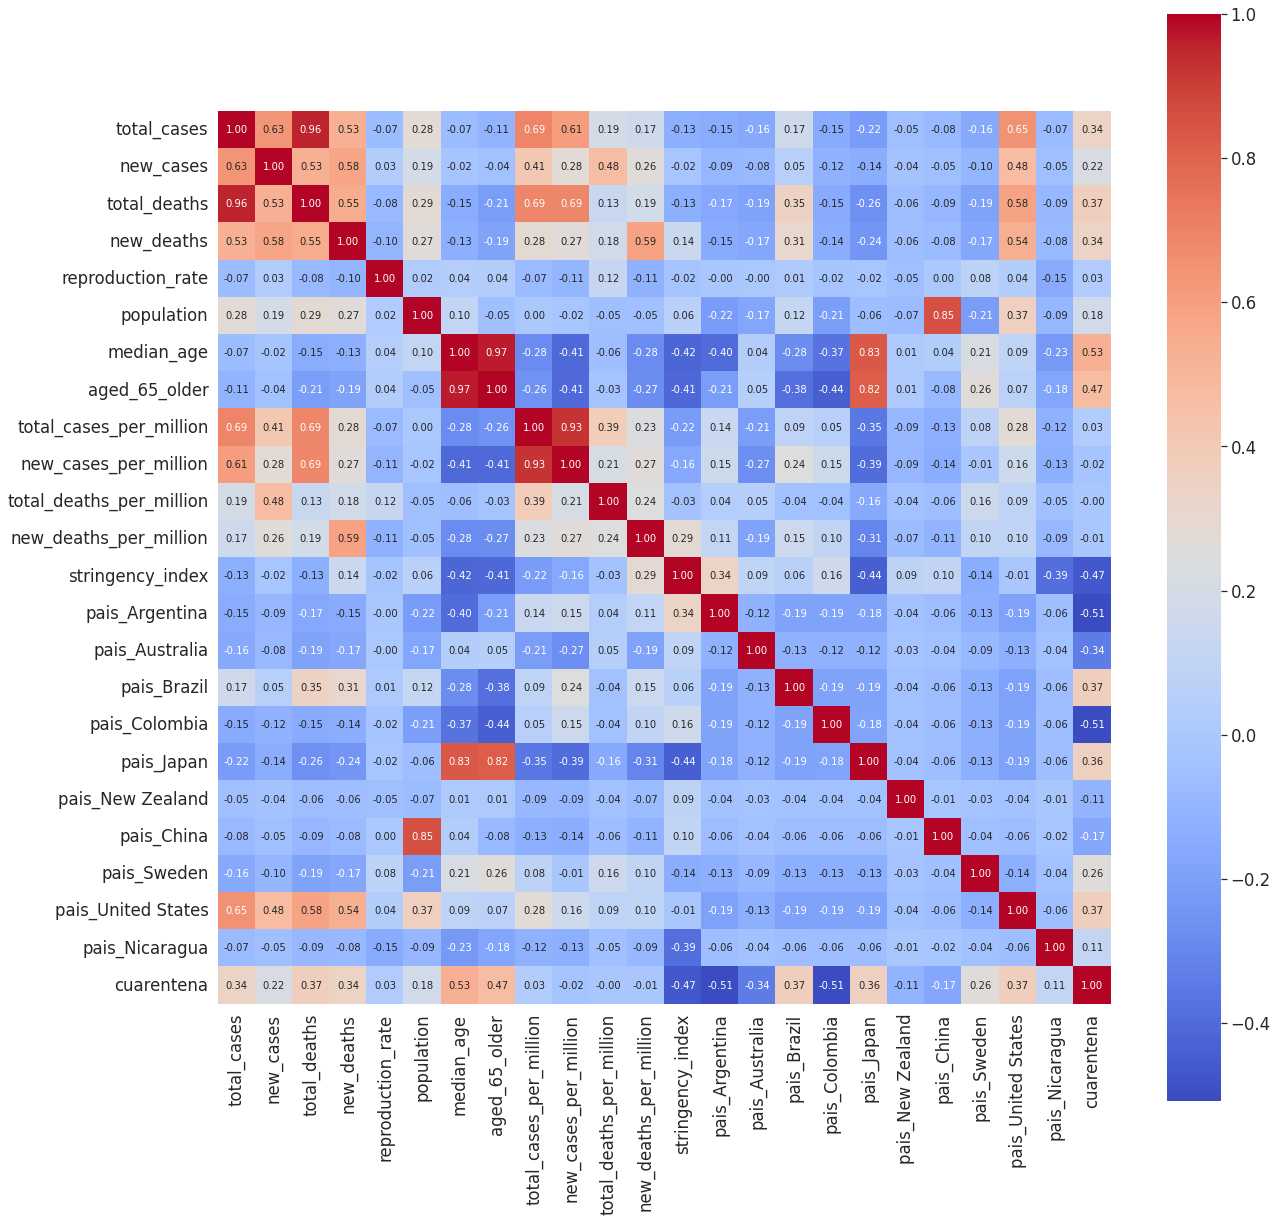

In [255]:
corr=data_escalado.corr()

plt.figure(figsize=(20,20))
ax=sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           cmap= 'coolwarm')
plt.show()

Ahora vamos hacer una regresion lineal para cada uno de los 10 paises anteriormente definidos yluego hacer un clasificador binario.

La regresión logística es un tipo de análisis de regresión que se utiliza para predecir el resultado
de una variable categórica en función de variables independientes. Modela la probabilidad de que una
muestra pertenezca a una clase en función de otras variables.

Ahora, podremos predecir usando nuestro set de prueba:

In [256]:
data_escalado.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
0,-0.565812,-0.386143,-0.653557,-0.603879,5.022526,6.011162,0.276814,-0.566591,-0.924962,-0.427499,...,0,0,0,0,1,0,0,0,2020-01-23,0
1,-0.565789,-0.383618,-0.653520,-0.593857,5.431936,6.011162,0.276814,-0.566591,-0.924958,-0.427487,...,0,0,0,0,1,0,0,0,2020-01-24,0
2,-0.565748,-0.380806,-0.653446,-0.582403,5.815757,6.011162,0.276814,-0.566591,-0.924951,-0.427466,...,0,0,0,0,1,0,0,0,2020-01-25,0
3,-0.565693,-0.378350,-0.653381,-0.585266,5.969286,6.011162,0.276814,-0.566591,-0.924941,-0.427446,...,0,0,0,0,1,0,0,0,2020-01-26,0
4,-0.565626,-0.376466,-0.653261,-0.568086,6.071638,6.011162,0.276814,-0.566591,-0.924930,-0.427411,...,0,0,0,0,1,0,0,0,2020-01-27,0


In [257]:
# Número de obsercaciones por clase
print("Número de observaciones por clase")
print(data_escalado['cuarentena'].value_counts())
print("")

print("Porcentaje de observaciones por clase")
print(100 * data_escalado['cuarentena'].value_counts(normalize=True))

Número de observaciones por clase
1    2490
0    1799
Name: cuarentena, dtype: int64

Porcentaje de observaciones por clase
1    58.055491
0    41.944509
Name: cuarentena, dtype: float64


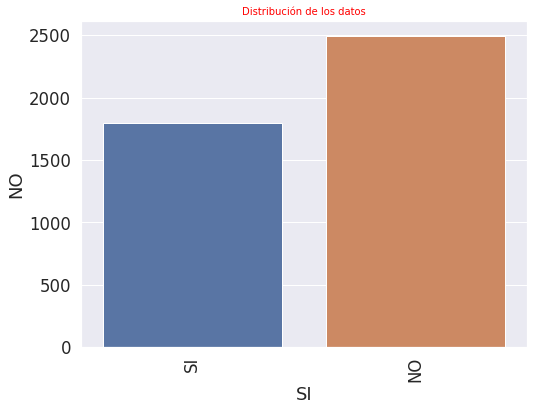

In [258]:
plt.figure(figsize=(8, 6))
plt.xticks(rotation=90)
sns.countplot(data = data_escalado, x = 'cuarentena')
plt.title("Distribución de los datos", size = 10, color='red')
plt.xticks(range(2), ['SI', 'NO'])
plt.xlabel("SI")
plt.ylabel("NO")
plt.show()

In [259]:
X = data_escalado[["new_cases_per_million", "reproduction_rate", "stringency_index"]]
y = data_escalado["cuarentena"]

In [260]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [261]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [262]:
#Creamos una instancia de la Regresión Logística
LR = LogisticRegression()

In [263]:
#Entrenamos la regresión logística con los datos de entrenamiento
LR = LogisticRegression().fit(X_train,y_train)

Ahora, podremos predecir usando nuestro set de prueba:

In [264]:
yhat = LR.predict(X_test)
yhat

array([1, 0, 0, ..., 1, 1, 0])

predict_proba devuelve estimaciones para todas las clases. La primer columna es la probabilidad de la clase 1, P(Y=1|X), y la segunda columna es la probabilidad de la clase 0, P(Y=0|X):

In [265]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.23109663, 0.76890337],
       [0.56316862, 0.43683138],
       [0.77325567, 0.22674433],
       ...,
       [0.22470748, 0.77529252],
       [0.24513358, 0.75486642],
       [0.74734069, 0.25265931]])

In [266]:
Score = LR.score(X_test, y_test)
Predict = LR.predict(X_test)

In [267]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

In [268]:
print('La precisión del modelo es de', Score)

La precisión del modelo es de 0.7070707070707071


In [269]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.7001998667554963
Porcentaje de aciertos sobre el set de evaluación: 0.7070707070707071


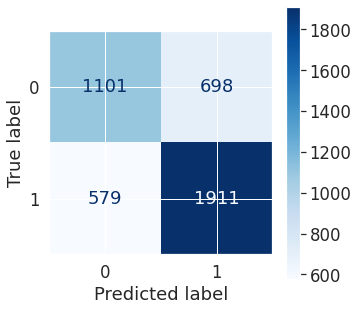

In [270]:
# Calcular la matriz de confusión
plt.rcParams["figure.figsize"] = (5, 5)
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR, X, y, cmap=plt.cm.Blues, values_format = '.0f')

Ahora vamos a mirar la matriz normalizada.

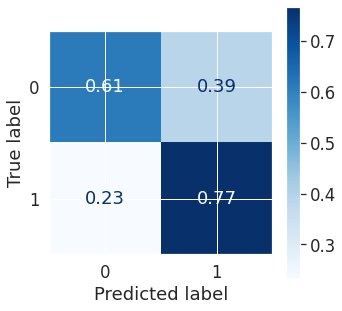

In [271]:
plt.rcParams["figure.figsize"] = (5, 5)
plot_confusion_matrix(LR, X, y, cmap=plt.cm.Blues, values_format = '.2f', normalize= 'true')

In [272]:
#Calculo la exactitud del modelo
from sklearn.metrics import accuracy_score
exactitud = accuracy_score(y_test, y_test_pred)
print('Exactitud del modelo:')
print(exactitud)

Exactitud del modelo:
0.7070707070707071


In [273]:
#Calculo la sensibilidad del modelo
from sklearn.metrics import recall_score
sensibilidad = recall_score(y_test, y_test_pred)
print('Sensibilidad del modelo:')
print(sensibilidad)

Sensibilidad del modelo:
0.7736351531291611


In [274]:
#Calculo el Puntaje F1 del modelo
from sklearn.metrics import f1_score
puntajef1 = f1_score(y_test, y_test_pred)
print('Puntaje F1 del modelo:')
print(puntajef1)

Puntaje F1 del modelo:
0.7550357374918779


In [275]:
#Calculo la curva ROC - AUC del modelo
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_test_pred)
print('Curva ROC - AUC del modelo:')
print(roc_auc)

Curva ROC - AUC del modelo:
0.6937205616392075


In [276]:
data_escalado.groupby('cuarentena').agg({'new_cases_per_million':[np.mean, np.std]}).sort_values([('new_cases_per_million','std')], ascending= False). head()

new_cases_per_million          
                            mean       std
cuarentena                                
0                       1.432101  1.909941
1                       1.348663  1.788996

Podemos ver que los nuevos casos por millon disminuyeron al aplicar la medida sanitaria de la cuarentena.

In [277]:
data_escalado.groupby('cuarentena').agg({'reproduction_rate':[np.mean, np.std]}).sort_values([('reproduction_rate','std')], ascending= False). head()

reproduction_rate          
                        mean       std
cuarentena                            
1                   0.023364  1.058255
0                  -0.032338  0.912866

Se puede observar que el promedio dio de reproduction_rate para los paises que no hicieron cuarentena que es cuarentena igual a cero dio negativa lo que indica las medidas que tomaron esos paises no fue eficiente a comparacion de los paises que si implementaron la cuarentena.

In [278]:
data_escalado.groupby('cuarentena').agg({'stringency_index':[np.mean, np.std]}).sort_values([('stringency_index','std')], ascending= False). head()

stringency_index          
                       mean       std
cuarentena                           
0                  0.547974  0.887129
1                 -0.395905  0.883648

* Ahora vamos hacer lo mismo pero con cada pais donde se realizo cuarentena donde se van a tomar fechas en las que hubo cuarentena y fechas donde no hubo cuarentena en ese pais y se va analizar como se vio influenciado los indicadores en esas fechas y si la medida implementada por cada gobierno con respecto a la cuarentena si fue eficaz.

# **Argentina**

In [279]:
data_argentina = data_escalado[(data_escalado["pais_Argentina"] == 1)] 

In [280]:
fecha_si = data_argentina.loc[(data_argentina['fecha'] >= '2020-03-19') & (data_argentina['fecha'] <= '2020-05-18')]
fecha_no = data_argentina.loc[(data_argentina['fecha'] >= '2020-08-01') & (data_argentina['fecha'] <= '2020-11-12')]
data_argentina = pd.concat([fecha_si, fecha_no], axis=0)
data_argentina.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
108,-0.565852,-0.386989,-0.653622,-0.603879,3.180184,-0.507614,-0.917839,-0.482172,-0.924898,-0.427351,...,0,0,0,0,0,0,0,0,2020-03-21,0
129,-0.565833,-0.386225,-0.653613,-0.602447,2.566070,-0.507614,-0.917839,-0.482172,-0.924792,-0.427266,...,0,0,0,0,0,0,0,0,2020-03-24,0
141,-0.565823,-0.385829,-0.653599,-0.603879,2.233425,-0.507614,-0.917839,-0.482172,-0.924739,-0.427140,...,0,0,0,0,0,0,0,0,2020-03-26,0
147,-0.565816,-0.386211,-0.653581,-0.599584,2.003132,-0.507614,-0.917839,-0.482172,-0.924698,-0.426970,...,0,0,0,0,0,0,0,0,2020-03-27,0
151,-0.565808,-0.386020,-0.653557,-0.598152,1.824015,-0.507614,-0.917839,-0.482172,-0.924651,-0.426756,...,0,0,0,0,0,0,0,0,2020-03-28,0


In [281]:
data_argentina['cuarentena'] = np.where((data_argentina['fecha'] >= '2020-03-19') & (data_argentina['fecha'] <= '2020-05-18'),1,0)
data_argentina.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
108,-0.565852,-0.386989,-0.653622,-0.603879,3.180184,-0.507614,-0.917839,-0.482172,-0.924898,-0.427351,...,0,0,0,0,0,0,0,0,2020-03-21,1
129,-0.565833,-0.386225,-0.653613,-0.602447,2.566070,-0.507614,-0.917839,-0.482172,-0.924792,-0.427266,...,0,0,0,0,0,0,0,0,2020-03-24,1
141,-0.565823,-0.385829,-0.653599,-0.603879,2.233425,-0.507614,-0.917839,-0.482172,-0.924739,-0.427140,...,0,0,0,0,0,0,0,0,2020-03-26,1
147,-0.565816,-0.386211,-0.653581,-0.599584,2.003132,-0.507614,-0.917839,-0.482172,-0.924698,-0.426970,...,0,0,0,0,0,0,0,0,2020-03-27,1
151,-0.565808,-0.386020,-0.653557,-0.598152,1.824015,-0.507614,-0.917839,-0.482172,-0.924651,-0.426756,...,0,0,0,0,0,0,0,0,2020-03-28,1


In [282]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [283]:
X = data_argentina[["new_cases_per_million", "reproduction_rate", "stringency_index"]]
y = data_argentina["cuarentena"]

In [284]:
#Creamos una instancia de la Regresión Logística
LR = LogisticRegression()

In [285]:
#Entrenamos la regresión logística con los datos de entrenamiento
LR = LogisticRegression().fit(X_train,y_train)

In [286]:
Score = LR.score(X_test, y_test)
Predict = LR.predict(X_test)

In [287]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

In [288]:
print('La precisión del modelo es de', Score)

La precisión del modelo es de 0.7070707070707071


In [289]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.7001998667554963
Porcentaje de aciertos sobre el set de evaluación: 0.7070707070707071


In [290]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[329 207]
 [170 581]]


In [291]:
nuevos_casos_argentina = data_argentina[['cuarentena', 'new_cases_per_million']].groupby('cuarentena', as_index = False).sum().sort_values('new_cases_per_million', ascending = False)
nuevos_casos_argentina

,cuarentena,new_cases_per_million
0,0,29.853642
1,1,-22.279528


In [292]:
reproduction_rate_argentina = data_argentina[['cuarentena', 'reproduction_rate']].groupby('cuarentena', as_index = False).sum().sort_values('reproduction_rate', ascending = False)
reproduction_rate_argentina

,cuarentena,reproduction_rate
1,1,33.291097
0,0,-12.346000


In [293]:
stringency_index_argentina = data_argentina[['cuarentena', 'stringency_index']].groupby('cuarentena', as_index = False).sum().sort_values('stringency_index', ascending = False)
stringency_index_argentina

,cuarentena,stringency_index
0,0,145.677660
1,1,103.260597


In [294]:
indicadores_argentina = pd.concat([nuevos_casos_argentina, reproduction_rate_argentina, stringency_index_argentina])

Se puede ver que en la epoca donde hicieron cuarentena los nuevos casos por millon dieron negativo lo q indica que se redujeron los casos y que la medida que tomo el gobierno fue eficiente, a pesar que el indice de rigurosidad cuando hubo cuarentena fue mas bajo y la tasa de repoducción del virus aumento siendo  las medidas para disminuir los contagios por covid fueron eficientes.

# **Colombia**

In [295]:
data_colombia = data_escalado[(data_escalado["pais_Colombia"] == 1)] 

In [296]:
fecha_si = data_colombia.loc[(data_colombia['fecha'] >= '2020-03-24') & (data_colombia['fecha'] <= '2020-08-30')]
fecha_no = data_colombia.loc[(data_colombia['fecha'] >= '2021-06-07') & (data_colombia['fecha'] <= '2021-10-12')]
data_colombia = pd.concat([fecha_si, fecha_no], axis=0)
data_colombia.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
132,-0.565826,-0.386143,-0.653622,-0.603879,2.259013,-0.481233,-0.865133,-1.020516,-0.924778,-0.427371,...,0,1,0,0,0,0,0,0,2020-03-25,0
137,-0.565824,-0.387112,-0.653613,-0.602447,1.721663,-0.481233,-0.865133,-1.020516,-0.924769,-0.427295,...,0,1,0,0,0,0,0,0,2020-03-26,0
163,-0.565807,-0.386116,-0.653595,-0.599584,1.824015,-0.481233,-0.865133,-1.020516,-0.924682,-0.427144,...,0,1,0,0,0,0,0,0,2020-03-29,0
174,-0.565799,-0.386088,-0.653585,-0.602447,1.772839,-0.481233,-0.865133,-1.020516,-0.924642,-0.427068,...,0,1,0,0,0,0,0,0,2020-03-30,0
181,-0.565790,-0.385925,-0.653567,-0.599584,1.516958,-0.481233,-0.865133,-1.020516,-0.924598,-0.426917,...,0,1,0,0,0,0,0,0,2020-03-31,0


In [297]:
data_colombia['cuarentena'] = np.where((data_colombia['fecha'] >= '2020-03-24') & (data_colombia['fecha'] <= '2020-08-30'),1,0)
data_colombia.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
132,-0.565826,-0.386143,-0.653622,-0.603879,2.259013,-0.481233,-0.865133,-1.020516,-0.924778,-0.427371,...,0,1,0,0,0,0,0,0,2020-03-25,1
137,-0.565824,-0.387112,-0.653613,-0.602447,1.721663,-0.481233,-0.865133,-1.020516,-0.924769,-0.427295,...,0,1,0,0,0,0,0,0,2020-03-26,1
163,-0.565807,-0.386116,-0.653595,-0.599584,1.824015,-0.481233,-0.865133,-1.020516,-0.924682,-0.427144,...,0,1,0,0,0,0,0,0,2020-03-29,1
174,-0.565799,-0.386088,-0.653585,-0.602447,1.772839,-0.481233,-0.865133,-1.020516,-0.924642,-0.427068,...,0,1,0,0,0,0,0,0,2020-03-30,1
181,-0.565790,-0.385925,-0.653567,-0.599584,1.516958,-0.481233,-0.865133,-1.020516,-0.924598,-0.426917,...,0,1,0,0,0,0,0,0,2020-03-31,1


In [298]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [299]:
X = data_colombia[["new_cases_per_million", "reproduction_rate", "stringency_index"]]
y = data_colombia["cuarentena"]

In [300]:
#Creamos una instancia de la Regresión Logística
LR = LogisticRegression()

In [301]:
#Entrenamos la regresión logística con los datos de entrenamiento
LR = LogisticRegression().fit(X_train,y_train)

In [302]:
Score = LR.score(X_test, y_test)
Predict = LR.predict(X_test)

In [303]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

In [304]:
print('La precisión del modelo es de', Score)

La precisión del modelo es de 0.9583333333333334


In [305]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.944954128440367
Porcentaje de aciertos sobre el set de evaluación: 0.9583333333333334


In [306]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[33  0]
 [ 2 13]]


In [307]:
nuevos_casos_colombia = data_colombia[['cuarentena', 'new_cases_per_million']].groupby('cuarentena', as_index = False).sum().sort_values('new_cases_per_million', ascending = False)
nuevos_casos_colombia

,cuarentena,new_cases_per_million
0,0,510.356001
1,1,-39.818608


In [308]:
reproduction_rate_colombia = data_colombia[['cuarentena', 'reproduction_rate']].groupby('cuarentena', as_index = False).sum().sort_values('reproduction_rate', ascending = False)
reproduction_rate_colombia

,cuarentena,reproduction_rate
1,1,64.700733
0,0,-80.038625


In [309]:
stringency_index_colombia = data_colombia[['cuarentena', 'stringency_index']].groupby('cuarentena', as_index = False).sum().sort_values('stringency_index', ascending = False)
stringency_index_colombia

,cuarentena,stringency_index
1,1,230.801972
0,0,-79.322714


In [310]:
indicadores_colombia = pd.concat([nuevos_casos_colombia, reproduction_rate_colombia, stringency_index_colombia])

En colombia cuando hubo cuarentena los casos nuevos disminuyeron, la tasa de reproduccion del virus aumento cuanto más altos son los valores, más rápida es la circulación del virus y el indice de rigurosidad aumento lo que indica que la medidda que se tomaron en este pais para combatir el virus fue eficiente.

# **Nueva Zelanda**

In [311]:
data_nueva_zelanda = data_escalado[(data_escalado["pais_New Zealand"] == 1)] 

In [312]:
fecha_si = data_nueva_zelanda.loc[(data_nueva_zelanda['fecha'] >= '2020-03-25') & (data_nueva_zelanda['fecha'] <= '2020-06-22')]
fecha_no = data_nueva_zelanda.loc[(data_nueva_zelanda['fecha'] >= '2020-08-02') & (data_nueva_zelanda['fecha'] <= '2020-10-15')]
data_nueva_zelanda = pd.concat([fecha_si, fecha_no], axis=0)
data_nueva_zelanda.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
166,-0.565822,-0.386539,-0.653636,-0.603879,1.491370,-0.696285,0.136267,0.142864,-0.922850,-0.427144,...,0,0,0,1,0,0,0,0,2020-03-29,0
253,-0.565758,-0.386798,-0.653632,-0.603879,-0.683618,-0.696285,0.136267,0.142864,-0.919675,-0.426766,...,0,0,0,1,0,0,0,0,2020-04-10,0
267,-0.565756,-0.387003,-0.653622,-0.602447,-0.837146,-0.696285,0.136267,0.142864,-0.919555,-0.426010,...,0,0,0,1,0,0,0,0,2020-04-11,0
277,-0.565753,-0.387139,-0.653618,-0.603879,-1.067439,-0.696285,0.136267,0.142864,-0.919403,-0.425632,...,0,0,0,1,0,0,0,0,2020-04-13,0
285,-0.565751,-0.387167,-0.653599,-0.599584,-1.169792,-0.696285,0.136267,0.142864,-0.919333,-0.424118,...,0,0,0,1,0,0,0,0,2020-04-14,0


In [313]:
data_nueva_zelanda['cuarentena'] = np.where((data_nueva_zelanda['fecha'] >= '2020-03-25') & (data_nueva_zelanda['fecha'] <= '2020-06-22'),1,0)
data_nueva_zelanda.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
166,-0.565822,-0.386539,-0.653636,-0.603879,1.491370,-0.696285,0.136267,0.142864,-0.922850,-0.427144,...,0,0,0,1,0,0,0,0,2020-03-29,1
253,-0.565758,-0.386798,-0.653632,-0.603879,-0.683618,-0.696285,0.136267,0.142864,-0.919675,-0.426766,...,0,0,0,1,0,0,0,0,2020-04-10,1
267,-0.565756,-0.387003,-0.653622,-0.602447,-0.837146,-0.696285,0.136267,0.142864,-0.919555,-0.426010,...,0,0,0,1,0,0,0,0,2020-04-11,1
277,-0.565753,-0.387139,-0.653618,-0.603879,-1.067439,-0.696285,0.136267,0.142864,-0.919403,-0.425632,...,0,0,0,1,0,0,0,0,2020-04-13,1
285,-0.565751,-0.387167,-0.653599,-0.599584,-1.169792,-0.696285,0.136267,0.142864,-0.919333,-0.424118,...,0,0,0,1,0,0,0,0,2020-04-14,1


In [314]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [315]:
X = data_nueva_zelanda[["new_cases_per_million", "reproduction_rate", "stringency_index"]]
y = data_nueva_zelanda["cuarentena"]

In [316]:
#Creamos una instancia de la Regresión Logística
LR = LogisticRegression()

In [317]:
#Entrenamos la regresión logística con los datos de entrenamiento
LR = LogisticRegression().fit(X_train,y_train)

In [318]:
Score = LR.score(X_test, y_test)
Predict = LR.predict(X_test)

In [319]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

In [320]:
print('La precisión del modelo es de', Score)

La precisión del modelo es de 1.0


In [321]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 1.0
Porcentaje de aciertos sobre el set de evaluación: 1.0


In [322]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[38  0]
 [ 0 48]]


In [323]:
nuevos_casos_nueva_zelanda = data_nueva_zelanda[['cuarentena', 'new_cases_per_million']].groupby('cuarentena', as_index = False).sum().sort_values('new_cases_per_million', ascending = False)
nuevos_casos_nueva_zelanda

,cuarentena,new_cases_per_million
0,0,-0.836515
1,1,-5.502201


In [324]:
reproduction_rate_nueva_zelanda = data_nueva_zelanda[['cuarentena', 'reproduction_rate']].groupby('cuarentena', as_index = False).sum().sort_values('reproduction_rate', ascending = False)
reproduction_rate_nueva_zelanda

,cuarentena,reproduction_rate
0,0,-1.546352
1,1,-15.846993


In [325]:
stringency_index_nueva_zelanda = data_nueva_zelanda[['cuarentena', 'stringency_index']].groupby('cuarentena', as_index = False).sum().sort_values('stringency_index', ascending = False)
stringency_index_nueva_zelanda

,cuarentena,stringency_index
1,1,24.439363
0,0,-1.498040


In [326]:
indicadores_nueva_zelanda = pd.concat([nuevos_casos_nueva_zelanda, reproduction_rate_nueva_zelanda, stringency_index_nueva_zelanda])

En Nueva zelanda en la epoca que hubo cuarentena disminuyeron los casos por covid, la tasa de reproducción disminuyo y se aumento el indice de rigurosidad siendo muy eficiente las medidas adoptadas por el gobierno.

# **Australia**

In [327]:
data_australia = data_escalado[(data_escalado["pais_Australia"] == 1)] 

In [328]:
fecha_si = data_australia.loc[(data_australia['fecha'] >= '2020-03-21') & (data_australia['fecha'] <= '2020-06-19')]
fecha_no = data_australia.loc[(data_australia['fecha'] >= '2020-09-05') & (data_australia['fecha'] <= '2020-12-15')]
data_australia = pd.concat([fecha_si, fecha_no], axis=0)
data_australia.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
124,-0.565694,-0.382458,-0.653604,-0.603879,2.719598,-0.599982,0.136267,0.170449,-0.923294,-0.426921,...,0,0,0,0,0,0,0,0,2020-03-24,0
142,-0.565630,-0.381311,-0.653581,-0.598152,2.028720,-0.599982,0.136267,0.170449,-0.922666,-0.426545,...,0,0,0,0,0,0,0,0,2020-03-26,0
153,-0.565561,-0.380615,-0.653576,-0.603879,1.209901,-0.599982,0.136267,0.170449,-0.921985,-0.426469,...,0,0,0,0,0,0,0,0,2020-03-28,0
162,-0.565532,-0.382703,-0.653567,-0.602447,0.826080,-0.599982,0.136267,0.170449,-0.921702,-0.426320,...,0,0,0,0,0,0,0,0,2020-03-29,0
167,-0.565500,-0.382253,-0.653562,-0.603879,0.544611,-0.599982,0.136267,0.170449,-0.921393,-0.426245,...,0,0,0,0,0,0,0,0,2020-03-30,0


In [329]:
data_australia['cuarentena'] = np.where((data_australia['fecha'] >= '2020-03-21') & (data_australia['fecha'] <= '2020-06-19'),1,0)
data_australia.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
124,-0.565694,-0.382458,-0.653604,-0.603879,2.719598,-0.599982,0.136267,0.170449,-0.923294,-0.426921,...,0,0,0,0,0,0,0,0,2020-03-24,1
142,-0.565630,-0.381311,-0.653581,-0.598152,2.028720,-0.599982,0.136267,0.170449,-0.922666,-0.426545,...,0,0,0,0,0,0,0,0,2020-03-26,1
153,-0.565561,-0.380615,-0.653576,-0.603879,1.209901,-0.599982,0.136267,0.170449,-0.921985,-0.426469,...,0,0,0,0,0,0,0,0,2020-03-28,1
162,-0.565532,-0.382703,-0.653567,-0.602447,0.826080,-0.599982,0.136267,0.170449,-0.921702,-0.426320,...,0,0,0,0,0,0,0,0,2020-03-29,1
167,-0.565500,-0.382253,-0.653562,-0.603879,0.544611,-0.599982,0.136267,0.170449,-0.921393,-0.426245,...,0,0,0,0,0,0,0,0,2020-03-30,1


In [330]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [331]:
X = data_australia[["new_cases_per_million", "reproduction_rate", "stringency_index"]]
y = data_australia["cuarentena"]

In [332]:
#Creamos una instancia de la Regresión Logística
LR = LogisticRegression()

In [333]:
#Entrenamos la regresión logística con los datos de entrenamiento
LR = LogisticRegression().fit(X_train,y_train)

In [334]:
Score = LR.score(X_test, y_test)
Predict = LR.predict(X_test)

In [335]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

In [336]:
print('La precisión del modelo es de', Score)

La precisión del modelo es de 1.0


In [337]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 1.0
Porcentaje de aciertos sobre el set de evaluación: 1.0


In [338]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[1 0]
 [0 4]]


In [339]:
nuevos_casos_australia = data_australia[['cuarentena', 'new_cases_per_million']].groupby('cuarentena', as_index = False).sum().sort_values('new_cases_per_million', ascending = False)
nuevos_casos_australia

,cuarentena,new_cases_per_million
0,0,-13.081431
1,1,-16.914918


In [340]:
reproduction_rate_australia = data_australia[['cuarentena', 'reproduction_rate']].groupby('cuarentena', as_index = False).sum().sort_values('reproduction_rate', ascending = False)
reproduction_rate_australia

,cuarentena,reproduction_rate
1,1,-33.639385
0,0,-39.553688


In [341]:
stringency_index_australia = data_australia[['cuarentena', 'stringency_index']].groupby('cuarentena', as_index = False).sum().sort_values('stringency_index', ascending = False)
stringency_index_australia

,cuarentena,stringency_index
0,0,22.473236
1,1,20.569141


In [342]:
indicadores_australia = pd.concat([nuevos_casos_australia, reproduction_rate_australia, stringency_index_australia])

En Australia los nuevos casos por millon por covid cuando hubo cuarentena disminuyeron, aunque la tasa de reproduccion del covid aumento con respecto a cuando no hubo cuarentena este sigue siendo negativo y el indice de rigurosidad disminuyo el cual no fue tan efectivo los controles estrictos que se tomaron pero de todas formas disminuyeron los nuevos casos por covid que era lo que se pretendia siendo eficiente las medidas adoptadas por el gobierno.

# **China**

In [343]:
data_china = data_escalado[(data_escalado["pais_China"] == 1)] 

In [344]:
fecha_si = data_china.loc[(data_china['fecha'] >= '2020-01-23') & (data_china['fecha'] <= '2020-04-08')]
fecha_no = data_china.loc[(data_china['fecha'] >= '2020-05-10') & (data_china['fecha'] <= '2020-10-20')]
data_china = pd.concat([fecha_si, fecha_no], axis=0)
data_china.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
0,-0.565812,-0.386143,-0.653557,-0.603879,5.022526,6.011162,0.276814,-0.566591,-0.924962,-0.427499,...,0,0,0,0,1,0,0,0,2020-01-23,0
1,-0.565789,-0.383618,-0.653520,-0.593857,5.431936,6.011162,0.276814,-0.566591,-0.924958,-0.427487,...,0,0,0,0,1,0,0,0,2020-01-24,0
2,-0.565748,-0.380806,-0.653446,-0.582403,5.815757,6.011162,0.276814,-0.566591,-0.924951,-0.427466,...,0,0,0,0,1,0,0,0,2020-01-25,0
3,-0.565693,-0.378350,-0.653381,-0.585266,5.969286,6.011162,0.276814,-0.566591,-0.924941,-0.427446,...,0,0,0,0,1,0,0,0,2020-01-26,0
4,-0.565626,-0.376466,-0.653261,-0.568086,6.071638,6.011162,0.276814,-0.566591,-0.924930,-0.427411,...,0,0,0,0,1,0,0,0,2020-01-27,0


In [345]:
data_china['cuarentena'] = np.where((data_china['fecha'] >= '2020-01-23') & (data_china['fecha'] <= '2020-04-08'),1,0)
data_china.head()

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,population,median_age,aged_65_older,total_cases_per_million,new_cases_per_million,...,pais_Brazil,pais_Colombia,pais_Japan,pais_New Zealand,pais_China,pais_Sweden,pais_United States,pais_Nicaragua,fecha,cuarentena
0,-0.565812,-0.386143,-0.653557,-0.603879,5.022526,6.011162,0.276814,-0.566591,-0.924962,-0.427499,...,0,0,0,0,1,0,0,0,2020-01-23,1
1,-0.565789,-0.383618,-0.653520,-0.593857,5.431936,6.011162,0.276814,-0.566591,-0.924958,-0.427487,...,0,0,0,0,1,0,0,0,2020-01-24,1
2,-0.565748,-0.380806,-0.653446,-0.582403,5.815757,6.011162,0.276814,-0.566591,-0.924951,-0.427466,...,0,0,0,0,1,0,0,0,2020-01-25,1
3,-0.565693,-0.378350,-0.653381,-0.585266,5.969286,6.011162,0.276814,-0.566591,-0.924941,-0.427446,...,0,0,0,0,1,0,0,0,2020-01-26,1
4,-0.565626,-0.376466,-0.653261,-0.568086,6.071638,6.011162,0.276814,-0.566591,-0.924930,-0.427411,...,0,0,0,0,1,0,0,0,2020-01-27,1


In [346]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

In [347]:
X = data_china[["new_cases_per_million", "reproduction_rate", "stringency_index"]]
y = data_china["cuarentena"]

In [348]:
#Creamos una instancia de la Regresión Logística
LR = LogisticRegression()

In [349]:
#Entrenamos la regresión logística con los datos de entrenamiento
LR = LogisticRegression().fit(X_train,y_train)

In [350]:
Score = LR.score(X_test, y_test)
Predict = LR.predict(X_test)

In [351]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

In [352]:
print('La precisión del modelo es de', Score)

La precisión del modelo es de 0.6521739130434783


In [353]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.5283018867924528
Porcentaje de aciertos sobre el set de evaluación: 0.6521739130434783


In [354]:
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_test, y_test_pred)
print('Matriz de Confusión:')
print(matriz)

Matriz de Confusión:
[[6 3]
 [5 9]]


In [355]:
nuevos_casos_china = data_china[['cuarentena', 'new_cases_per_million']].groupby('cuarentena', as_index = False).sum().sort_values('new_cases_per_million', ascending = False)
nuevos_casos_china

,cuarentena,new_cases_per_million
0,0,-0.421302
1,1,-31.417323


In [356]:
reproduction_rate_china = data_china[['cuarentena', 'reproduction_rate']].groupby('cuarentena', as_index = False).sum().sort_values('reproduction_rate', ascending = False)
reproduction_rate_china

,cuarentena,reproduction_rate
1,1,4.938436
0,0,-0.811558


In [357]:
stringency_index_china = data_china[['cuarentena', 'stringency_index']].groupby('cuarentena', as_index = False).sum().sort_values('stringency_index', ascending = False)
stringency_index_china

,cuarentena,stringency_index
1,1,58.897901
0,0,1.168571


In [358]:
indicadores_china = pd.concat([nuevos_casos_china, reproduction_rate_china, stringency_index_china])

En China los casos nuevos por covid disminuyeron, la tasa de reproduccion aumento y el indice de rigurosidad aumento demasiado gracias a los estrictos controles que se tomaron en ese pais.

# **Nuevos paises**

In [361]:
data_cuarentena = pd.read_csv('/content/gdrive/My Drive/Data_Science_Acamica/Proyectos/stay-at-home-covid.csv')
data_cuarentena.Day = pd.to_datetime(data_cuarentena.Day)

In [362]:
data_cuarentena.head()

,Entity,Code,Day,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0


In [363]:
nuevos_paises = ["Germany","Nigeria","Russia","Vietnam","France","India","Poland","Turkey", "Chile"]

In [364]:
cuarentena_paises = data_cuarentena[data_cuarentena.Entity.isin(nuevos_paises)]
cuarentena_paises.set_index("Day", inplace=True)
cuarentena_paises.stay_home_requirements.replace(1,0, inplace=True)
cuarentena_paises.stay_home_requirements.replace([3,2],1, inplace=True)

In [365]:
list = []

for i in nuevos_paises:

    dt = datos_paises[(datos_paises.pais == i)]
    dt.drop(columns="pais", inplace=True)
    dt.fillna(0,inplace=True)
    dt.set_index("fecha", inplace=True)
    dt["y_cuarentena"] = cuarentena_paises[cuarentena_paises.Entity == i].stay_home_requirements
    list.append(dt)

dt_modelo = pd.concat(list)

In [366]:
dt_modelo.reset_index(drop=True)

,new_cases_per_million,reproduction_rate,stringency_index,y_cuarentena
0,NaN,NaN,NaN,0
1,NaN,NaN,NaN,0
2,NaN,NaN,NaN,0
3,NaN,NaN,NaN,0
4,NaN,NaN,NaN,0
...,...,...,...,...
7193,NaN,NaN,NaN,0
7194,NaN,NaN,NaN,0
7195,NaN,NaN,NaN,0
7196,NaN,NaN,NaN,0


In [367]:
dt_modelo.isna().sum()

new_cases_per_million    6462
reproduction_rate        6462
stringency_index         6462
y_cuarentena                0
dtype: int64

In [368]:
dt_modelo.dropna(inplace=True)

In [369]:
X = dt_modelo.drop(columns=["y_cuarentena"])
y = dt_modelo.y_cuarentena

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [371]:
LR = LogisticRegression()

In [372]:
LR = LogisticRegression().fit(X_train,y_train)

In [373]:
Score = LR.score(X_test, y_test)
Predict = LR.predict(X_test)

In [374]:
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

In [375]:
print('La precisión del modelo es de', Score)

La precisión del modelo es de 0.9095022624434389


In [376]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aciertos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aciertos sobre el set de evaluación:',test_acc)

Porcentaje de aciertos sobre el set de entrenamiento: 0.887378640776699
Porcentaje de aciertos sobre el set de evaluación: 0.9095022624434389


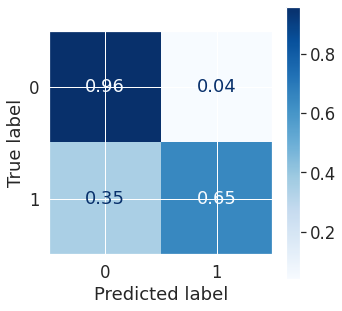

In [377]:
plt.rcParams["figure.figsize"] = (5, 5)
plot_confusion_matrix(LR, X, y, cmap=plt.cm.Blues, values_format = '.2f', normalize= 'true')

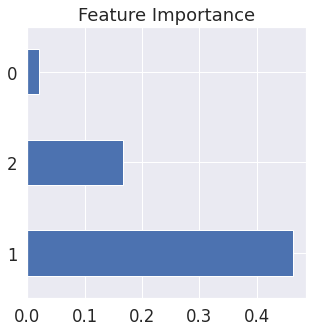

In [380]:
importance = LR.coef_[0]
feat_importances = pd.Series(importance)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')

A futuro me gustaria probar como es la relación entre casos de contagios, muertes y los recuperados, tambien me gustaria analizar otras variables como es la edad de la población y las enfermedades que tenia la población en especial la audlta mayor como influyeron con la cantidad de contagios, en uci y de muertes.
Analizar en el 2021 si hubo una disminución en los contagios y rata de reproducción cuando se empezaron aplicar las vacunas.

# **Conslusiones**

* El Crecimiento Exponencial solo se ajustará a la epidemia al principio. En algún momento, las personas curadas ya no propagarán el virus y cuando casi todos estén o hayan estado infectados, el crecimiento se detendrá.
* El continente con mas casos nuevos por covid fue Norte America y con menos contagios fue Africa.
* Al calcular la Kmundial y calcular el RMSE del modelo dio un error muy alto al compararlo con los demas paises  eso debido a que es muy dificil hacer un modelo que se aproxime al **kworld** y que se pueda utilizar para predecir la cantidad de contagios. Aunque el virus es el mismo , las formas de propagarse van a variar en los diferentes paises dependiendo de las medidas que tomaron cada pais (cuarentena, vacunas, tapabocas, detectar grupos de infección y atacarlos rapidamente), la sobrepoblación tambien influyel la pobreza, los servicios de salud no sean propicias,  Esto indica que para poder predecir con una precision considerable la cantidad de contagios hay que tener en cuenta la poblacion de paises bajo las mismas politicas publicas contra el virus, en determinados periodos de tiempo. 
* El indice de rigurosidad en el intervalo de tiempo de abril a julio  los continentes de Africa, Asia y Europa presentaron un alto indice de rigurosidad eso debido a todas las medidas que se tomaron para frenar la propagación del covid, con respecto a Norte Armerica y sur America presentaron un indice de rigurosidad muy bajo que se sostubo durante toda la pandemia.
* la tasa de reproducción del virus en el continente de Sur America presenta grandes fluctuaciones sobre la reproducción del virus mientras que en los otros continentes es estatico, esto se debe a que en sur america fueron menos estrictas las medidas para combatir el covid ya que hay mas trabajos informales donde la economia no se podia parar y se presentaron menos ayudas por parte del gobierno.
* Al analizar los 5 paises donde hicieron cuarentena y las fechas en las q hicieron y las fechas en las que no hubo cuarentena se puede observar en todos los paises que con la medida adopatada por el gobierno de hacer cuarentena los nuevos casos por covid por millon disminuyeron a pesar de que en algunos paises la rata de reproduccion aumentara y el indice de rigurosidad disminuyera esto debido a que en algunos paises la cuarentena fue parcial (sectorizada) ya que no se podia frenar completamente la economia del pais, pero si las medidas que se tomaron disminuyeron los contagios.

# **Bibliografia**

* https://www.as.coa.org
* https://oecd.org
* https://www.wsj.com
* https://www.conexiones365.com/nota/expo-med/sistemas-de-salud/7-paises-control-covid
*  https://www.bbc.com/mundo/noticias-53541458.
* https://www.bbc.com/mundo/noticias-america-latina-52248497
* https://ourworldindata.org/covid-stay-home-restrictions